<h1><b>[I - Feature extraction]</b></h1>

This notebook extracts the main features.

It can be run with "Run All"

The features will be saved in a csv called `train_df.csv`, and `test_df.csv`

____________________________

<h2>1) Initialisation</h2>

In [2]:
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)  

Let's read the data, with geopandas.

We use "pyogrio" for a faster reading (can be installed with pip - but it is not mandatory)

In [3]:
import time
start = time.time()

train_df_geojson = gpd.read_file('data/train.geojson', engine="pyogrio")
test_df_geojson = gpd.read_file('data/test.geojson', engine="pyogrio")

end = time.time()
print("Reading time:", end - start,"s")

Reading time: 162.6299431324005 s


In [4]:
train_df = train_df_geojson.copy()
test_df = test_df_geojson.copy()

Let's list all the columns

In [5]:
train_df.dtypes

urban_type                object
geography_type            object
change_type               object
img_red_mean_date1       float64
img_green_mean_date1     float64
img_blue_mean_date1      float64
img_red_std_date1        float64
img_green_std_date1      float64
img_blue_std_date1       float64
img_red_mean_date2       float64
img_green_mean_date2     float64
img_blue_mean_date2      float64
img_red_std_date2        float64
img_green_std_date2      float64
img_blue_std_date2       float64
img_red_mean_date3       float64
img_green_mean_date3     float64
img_blue_mean_date3      float64
img_red_std_date3        float64
img_green_std_date3      float64
img_blue_std_date3       float64
img_red_mean_date4       float64
img_green_mean_date4     float64
img_blue_mean_date4      float64
img_red_std_date4        float64
img_green_std_date4      float64
img_blue_std_date4       float64
img_red_mean_date5       float64
img_green_mean_date5     float64
img_blue_mean_date5      float64
img_red_st

In [6]:
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df shape: (296146, 45)
test_df shape: (120526, 44)


In [7]:
train_df.head()

urban_type                    geography_type change_type  \
0  Sparse Urban           Dense Forest,Grass Land        Road   
1  Sparse Urban           Dense Forest,Grass Land        Road   
2  Sparse Urban           Dense Forest,Grass Land        Road   
3         Rural           Dense Forest,Grass Land        Road   
4   Dense Urban  Sparse Forest,Dense Forest,Farms  Demolition   

   img_red_mean_date1  img_green_mean_date1  img_blue_mean_date1  \
0           93.371775            107.291113            89.827379   
1           96.071674            107.061702            90.755556   
2          101.212148            113.462178            95.670574   
3           94.463311             99.995531            84.470046   
4          151.883646            191.710197           211.569244   

   img_red_std_date1  img_green_std_date1  img_blue_std_date1  \
0          29.812040            28.328368           25.324294   
1          24.896240            22.275180           22.080686   
2          24.179684            21.873401           21.285197   
3          26.869852            23.767679           19.351983   
4          52.465332            59.441844           52.304349   

   img_red_mean_date2  img_green_mean_date2  img_blue_mean_date2  \
0          125.773062            139.833243           134.900701   
1          133.097679            145.385190           137.092518   
2          120.713490            131.633447           124.436492   
3          114.819776            127.827828           120.435373   
4          141.514462            171.079581           181.960612   

   img_red_std_date2  img_green_std_date2  img_blue_std_date2  \
0          28.269984            28.264907           25.008032   
1          23.683964            21.651242           20.271657   
2          28.951475            25.329365           22.505835   
3          34.091970            27.963117           23.901639   
4          24.436771            34.297473           41.600845   

   img_red_mean_date3  img_green_mean_date3  img_blue_mean_date3  \
0          150.766726            158.964529           149.356684   
1          184.480155            186.896779           174.235331   
2          148.150431            158.490141           148.571269   
3          148.322747            156.855136           148.180798   
4          170.365008            180.274159           186.818552   

   img_red_std_date3  img_green_std_date3  img_blue_std_date3  \
0          55.745311            47.576383           42.723218   
1          42.130924            38.138137           35.142246   
2          58.434034            48.106798           43.902810   
3          51.046935            44.444291           40.558345   
4          32.054249            40.833531           48.325621   

   img_red_mean_date4  img_green_mean_date4  img_blue_mean_date4  \
0           92.291347             88.794250            79.570064   
1          111.001421            102.096357            91.447834   
2           94.519603             91.331925            81.746626   
3           91.731693             89.100710            79.430155   
4          108.124000             97.851854            94.141506   

   img_red_std_date4  img_green_std_date4  img_blue_std_date4  \
0          39.819949            30.864230           28.189604   
1          37.129531            28.089549           25.901238   
2          42.510625            33.189102           30.522871   
3          39.111827            30.762028           28.337671   
4          27.578335            28.158172           27.306766   

   img_red_mean_date5  img_green_mean_date5  img_blue_mean_date5  \
0          104.614233            100.950353           102.844339   
1          110.445556            103.413826           104.835541   
2           98.734466             97.495577            99.197153   
3           90.506679             90.076099            92.412922   
4          155.293576            140.674732           131.007948   

   im

These functions plot some statistics for given columns

In [8]:
def plotInfos(df, column_names, hue="change_type"):
    
    n = len(column_names)
    if n <= 5:
        fig, axes = plt.subplots(1, 5, figsize=(30, 5))

        i = 0
        for column_name in column_names:
            category_count = len(df[column_name].value_counts())
            nan_count = df[column_name].isna().sum()
            axes[i].set_title(f"{column_name}: {len(df)-nan_count}/{len(df)}, {category_count} categories")

            column_type = df[column_name].dtype
            if column_type in ['object'] or category_count < 10:
                sns.countplot(ax=axes[i], x=column_name, data=df, hue=hue)

            elif column_type in ['float64', 'int64']:
                sns.histplot(ax=axes[i], x=column_name, data=df, kde=True, hue=hue)
            i += 1

        plt.show()
    else:
        
        nbLigs = n // 5
        if n % 5 != 0:
            nbLigs += 1
        
        fig, axes = plt.subplots(nbLigs, 5, figsize=(30, 5*nbLigs))

        i = 0
        for column_name in column_names:
            lig = i // 5
            col = i % 5
            category_count = len(df[column_name].value_counts())
            nan_count = df[column_name].isna().sum()
            axes[lig, col].set_title(f"{column_name}: {len(df)-nan_count}/{len(df)}, {category_count} categories")


            column_type = df[column_name].dtype
            if column_type in ['object'] or category_count < 10:
                sns.countplot(ax=axes[lig, col], x=column_name, data=df, hue=hue)

            elif column_type in ['float64', 'int64']:
                sns.histplot(ax=axes[lig, col], x=column_name, data=df, kde=True, hue=hue)
            i += 1
            
        plt.show()

In [9]:
def printInfos(df, column_name, showAsObject=False, hue="change_type"):
    NB_INPUTS = len(df)
    print("===",column_name,"===")
    column_type = df[column_name].dtype
    print("Type :", column_type)
    category_count = len(df[column_name].value_counts())
    nan_count = df[column_name].isna().sum()
    print("Missing values (NaN) :", nan_count,"/", NB_INPUTS)
    print("Nb of different values :", category_count)
    print("=== Value counts ===")
    print(df[column_name].value_counts())
    print("=== Data description ===")
    if(showAsObject) or category_count < 10:
        print(df[column_name].astype(str).describe())
    else:
        print(df[column_name].describe())


    if column_type in ['object'] or category_count < 10:
        # Bar plot pour les variables catégoriques
        plt.figure(figsize=(5, 3))
        sns.countplot(x=column_name, data=df, hue=hue)
        plt.title(f'{column_name} - {NB_INPUTS-nan_count}/{NB_INPUTS}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

    elif column_type in ['float64', 'int64']:
        # Histogram pour les variables numériques
        plt.figure(figsize=(5, 3))
        sns.histplot(x=column_name, data=df, kde=False, hue=hue)
        plt.title(f'{column_name} - {NB_INPUTS-nan_count}/{NB_INPUTS}')
        plt.show()

In [10]:
def plotOneHot(df, column_name):
    for change_type in df["change_type"].unique():
        plt.bar(change_type, df[df["change_type"]==change_type][column_name].mean())
    plt.ylabel("mean")
    plt.xlabel(column_name)
    plt.show()

In [11]:
def plotOneHotDouble(df, column_name1, column_name2):
    maxVal = -np.inf
    for change_type in df["change_type"].unique():
        val = (df[df["change_type"]==change_type][column_name1]*df[df["change_type"]==change_type][column_name2]).mean()
        maxVal = max(maxVal, val)
        plt.bar(change_type, val)
    plt.ylabel("mean")
    plt.xlabel(column_name1+" & "+column_name2)
    plt.show()

Finally, we can look at the proportion in each label: it is an unbalanced dataset !

=== change_type ===
Type : object
Missing values (NaN) : 0 / 296146
Nb of different values : 6
=== Value counts ===
Residential      148435
Commercial       100422
Demolition        31509
Road              14305
Industrial         1324
Mega Projects       151
Name: change_type, dtype: int64
=== Data description ===
count          296146
unique              6
top       Residential
freq           148435
Name: change_type, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


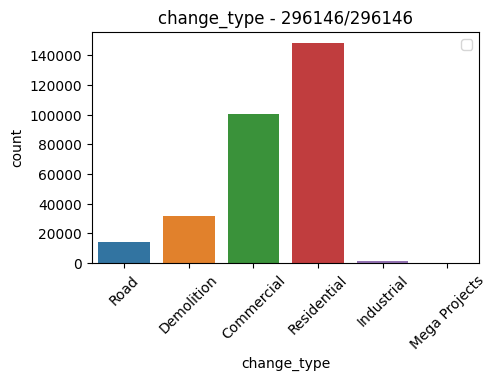

In [12]:
printInfos(train_df, "change_type")

<h2>2) Missing values</h2>

Let's see if there are missing values

In [13]:
def missing_values_table(df):
    # Nombre de valeurs manquantes
    mis_val = df.isnull().sum()

    # Pourcentage de valeurs manquantes
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Création d'un tableau 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing values', 1 : '% of missing values'})

    # Tri de la table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of missing values', ascending=False).round(1)

    # Print some summary information
    print ("The database contains " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns with missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [14]:
missing = missing_values_table(train_df)
print("=== train_df : missing values columns ===")
missing

The database contains 45 columns.
There are 40 columns with missing values.
=== train_df : missing values columns ===


Missing values  % of missing values
img_red_mean_date1              1954                  0.7
img_green_std_date3             1954                  0.7
img_blue_std_date5              1954                  0.7
img_green_std_date5             1954                  0.7
img_red_std_date5               1954                  0.7
img_blue_mean_date5             1954                  0.7
img_green_mean_date5            1954                  0.7
img_red_mean_date5              1954                  0.7
img_blue_std_date4              1954                  0.7
img_green_std_date4             1954                  0.7
img_red_std_date4               1954                  0.7
img_green_mean_date1            1954                  0.7
img_green_mean_date4            1954                  0.7
img_red_mean_date4              1954                  0.7
img_blue_std_date3              1954                  0.7
img_blue_mean_date4             1954                  0.7
img_red_std_date3               1954                  0.7
img_green_mean_date2            1954                  0.7
img_blue_mean_date1             1954                  0.7
img_blue_mean_date3             1954                  0.7
img_green_std_date1             1954                  0.7
img_blue_std_date1              1954                  0.7
img_red_mean_date2              1954                  0.7
img_red_std_date1               1954                  0.7
img_blue_mean_date2             1954                  0.7
img_red_std_date2               1954                  0.7
img_green_std_date2             1954                  0.7
img_blue_std_date2              1954                  0.7
img_red_mean_date3              1954                  0.7
img_green_mean_date3            1954                  0.7
date3                           1448                  0.5
change_status_date3             1448                  0.5
date4                           1448                  0.5
change_status_date4             1448                  0.5
date0                           1383                  0.5
change_status_date0             1383                  0.5
date1                           1383                  0.5
change_status_date1             1383                  0.5
date2                           1383                  0.5
change_status_date2             1383                  0.5

In [15]:
missing = missing_values_table(test_df)
print("=== test_df : missing values columns ===")
missing

The database contains 44 columns.
There are 40 columns with missing values.
=== test_df : missing values columns ===


Missing values  % of missing values
change_status_date4              729                  0.6
date2                            729                  0.6
change_status_date0              729                  0.6
date1                            729                  0.6
change_status_date1              729                  0.6
date0                            729                  0.6
change_status_date2              729                  0.6
date3                            729                  0.6
change_status_date3              729                  0.6
date4                            729                  0.6
img_green_mean_date1             624                  0.5
img_blue_std_date5               624                  0.5
img_green_std_date5              624                  0.5
img_red_std_date5                624                  0.5
img_blue_mean_date5              624                  0.5
img_green_mean_date5             624                  0.5
img_red_mean_date5               624                  0.5
img_blue_std_date4               624                  0.5
img_green_std_date4              624                  0.5
img_red_std_date4                624                  0.5
img_red_mean_date1               624                  0.5
img_green_mean_date4             624                  0.5
img_red_std_date2                624                  0.5
img_blue_mean_date1              624                  0.5
img_red_std_date1                624                  0.5
img_green_std_date1              624                  0.5
img_blue_std_date1               624                  0.5
img_red_mean_date2               624                  0.5
img_green_mean_date2             624                  0.5
img_blue_mean_date2              624                  0.5
img_green_std_date2              624                  0.5
img_red_mean_date4               624                  0.5
img_blue_std_date2               624                  0.5
img_red_mean_date3               624                  0.5
img_green_mean_date3             624                  0.5
img_blue_mean_date3              624                  0.5
img_red_std_date3                624                  0.5
img_green_std_date3              624                  0.5
img_blue_std_date3               624                  0.5
img_blue_mean_date4              624                  0.5

There are somes data that are missing (but not that much).

We can plot their location:

=== train_df : missing values ===


<AxesSubplot:>

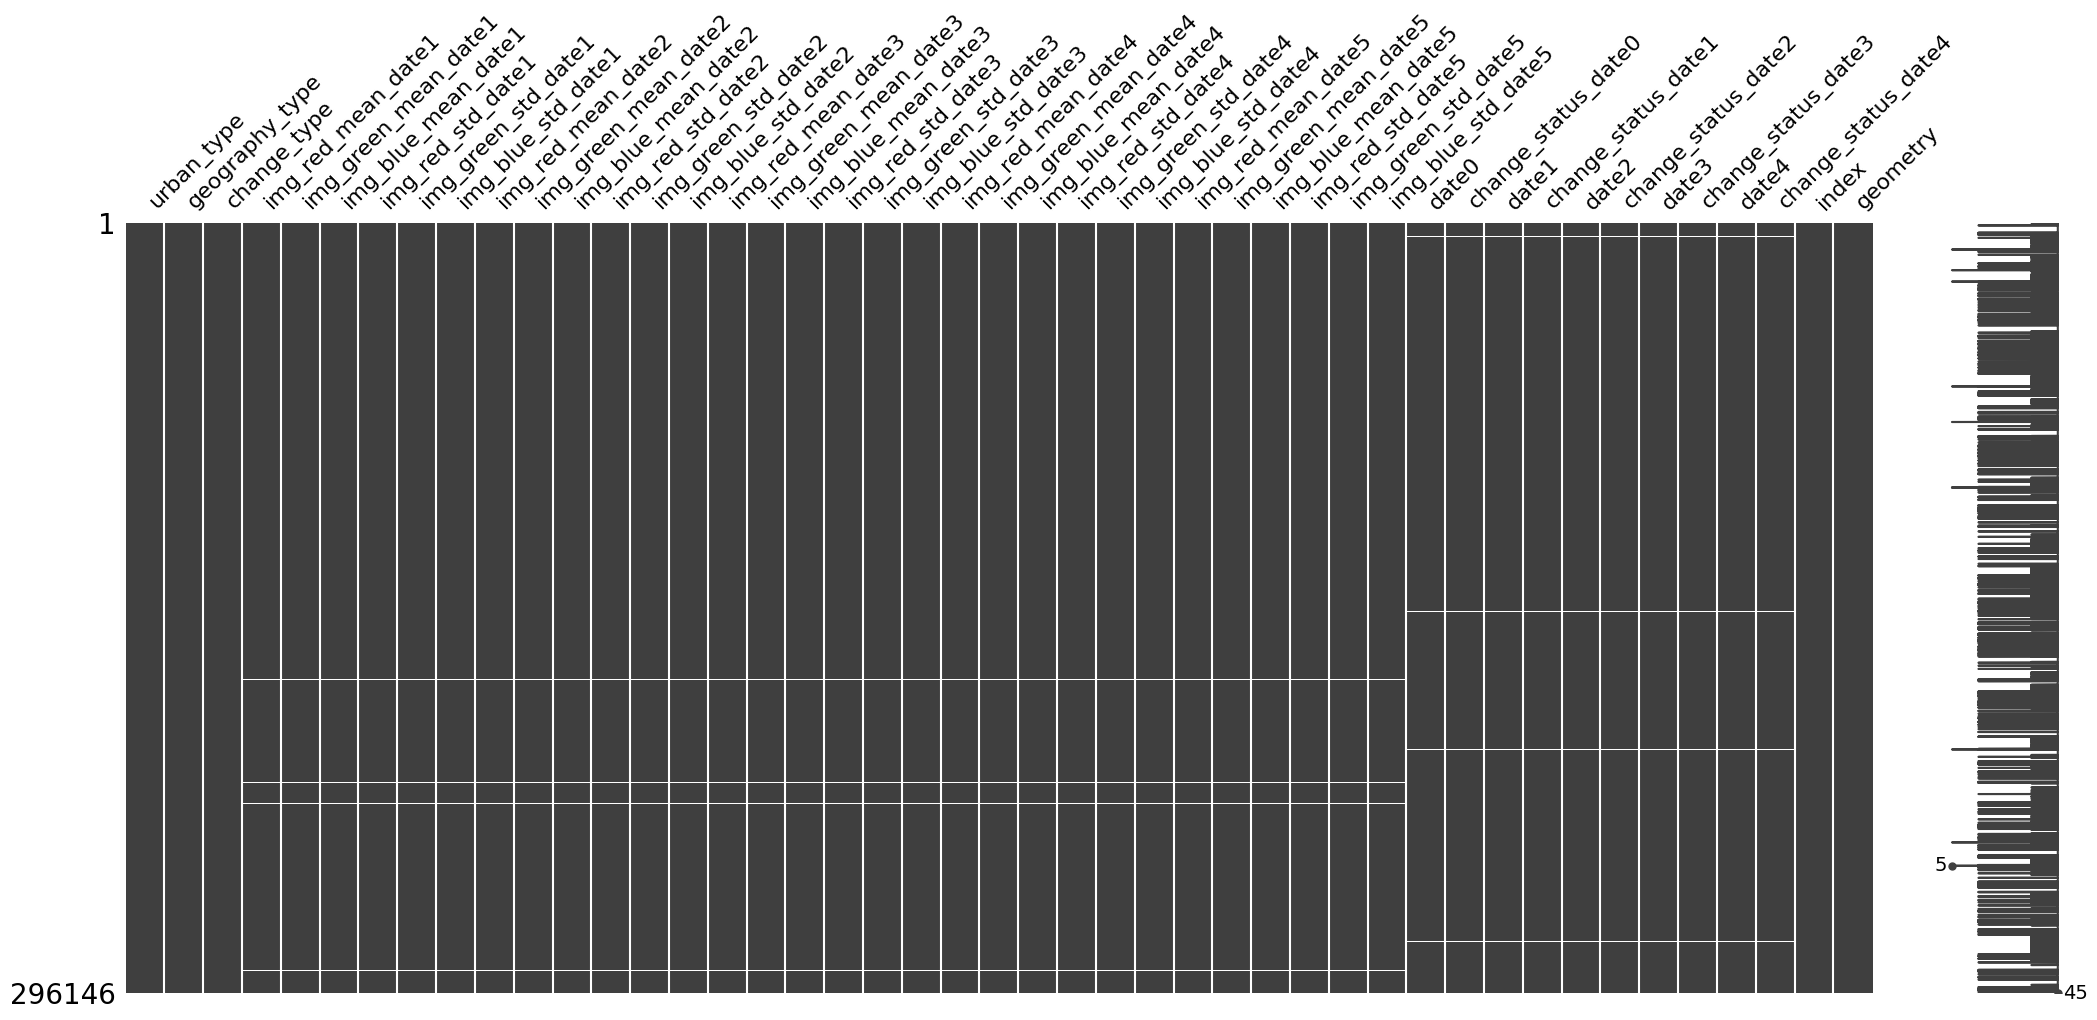

In [16]:
print("=== train_df : missing values ===")
msno.matrix(train_df)#, figsize=(15,15))

We see that some of our data contains either no dates, or no image data!

Let's see to which label they belong

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


=== change_type ===
Type : object
Missing values (NaN) : 0 / 1954
Nb of different values : 5
=== Value counts ===
Residential    1163
Commercial      509
Demolition      242
Road             39
Industrial        1
Name: change_type, dtype: int64
=== Data description ===
count            1954
unique              5
top       Residential
freq             1163
Name: change_type, dtype: object


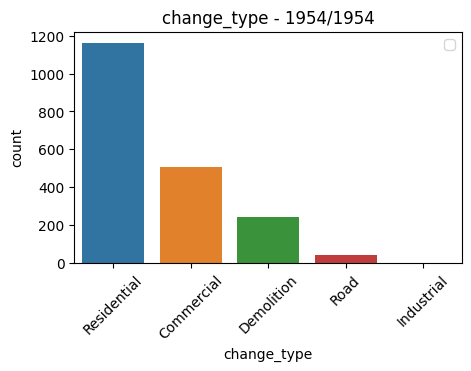

In [17]:
df_IMG_NULL = train_df.loc[train_df["img_red_mean_date1"].isnull()]
printInfos(df_IMG_NULL, "change_type")

They are many different change_types.

Now let's look at our test data:

=== test_df : missing values ===


<AxesSubplot:>

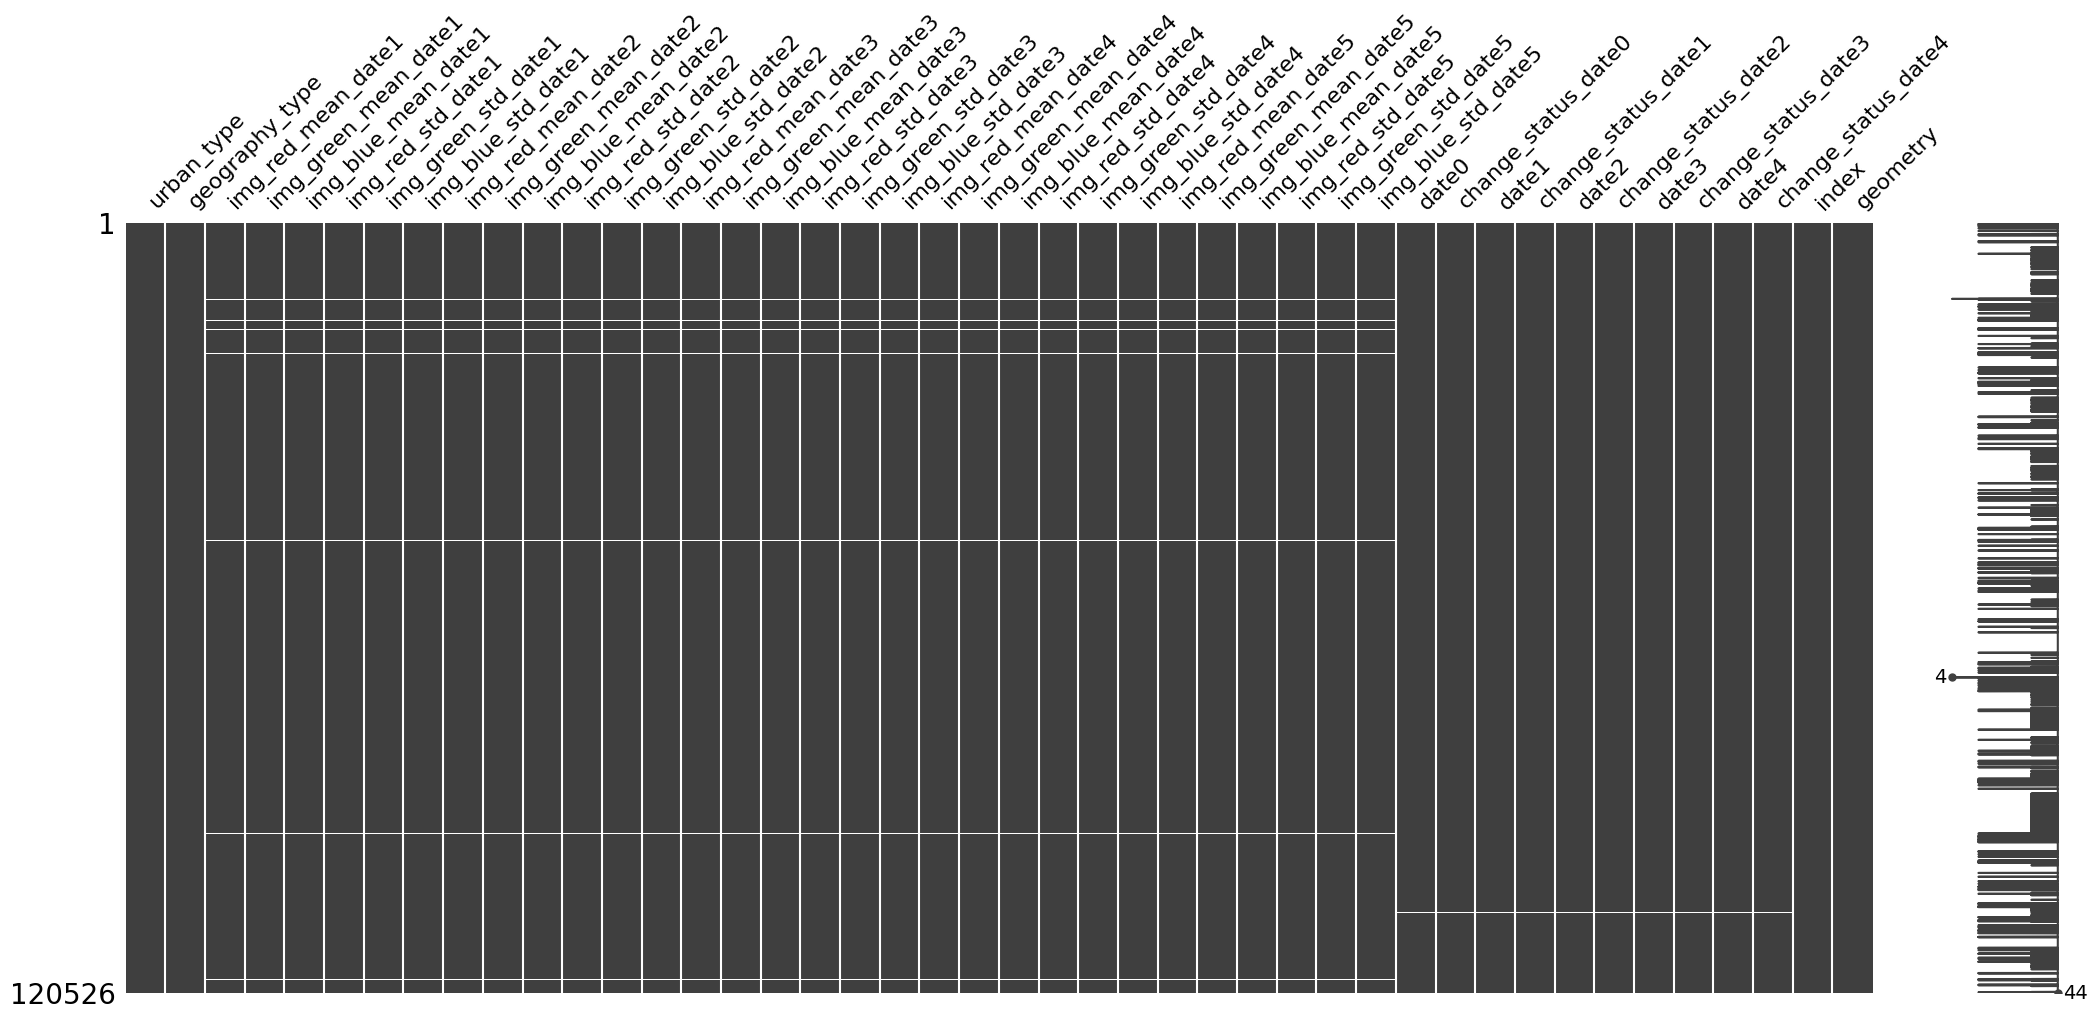

In [18]:
print("=== test_df : missing values ===")
msno.matrix(test_df)#, figsize=(15,15))

There are not so many missing values

We can either drop them, or impute them

In [19]:
# We could drop the data...
"""
Dropping the empty training rows
train_df = train_df.dropna(axis=0)
train_df = train_df.reset_index(drop=True)
"""
""

''

Let's impute the missing values for the training dataset:

We impute each missing value with the most frequent value among the data with the same change_type

In [20]:
change_types = train_df["change_type"].unique()
for change_type in change_types:
    for column in train_df.columns:
        if column == "geometry":
            continue
        train_df.loc[(train_df["change_type"]==change_type) & (train_df[column].isnull()), column] = train_df.loc[(train_df["change_type"]==change_type), column].mode()[0]

<h2>3) Column: urban_type</h2>

This column is a categorical column which indicates the urban type.

Let's print some information about it:

=== urban_type ===
Type : object
Missing values (NaN) : 0 / 296146
Nb of different values : 17
=== Value counts ===
Dense Urban                           89427
Sparse Urban                          69189
Industrial                            60411
N,A                                   36682
Rural                                 20428
Sparse Urban,Industrial                8129
Dense Urban,Industrial                 7223
Sparse Urban,Urban Slum                1948
Urban Slum                             1472
Dense Urban,Urban Slum                  669
Rural,Industrial                        188
Urban Slum,Industrial                   181
Sparse Urban,Dense Urban                 74
Dense Urban,Rural                        52
Sparse Urban,Urban Slum,Industrial       47
Sparse Urban,Rural                       20
Urban Slum,Rural                          6
Name: urban_type, dtype: int64
=== Data description ===
count          296146
unique             17
top       Dense Urban
freq          

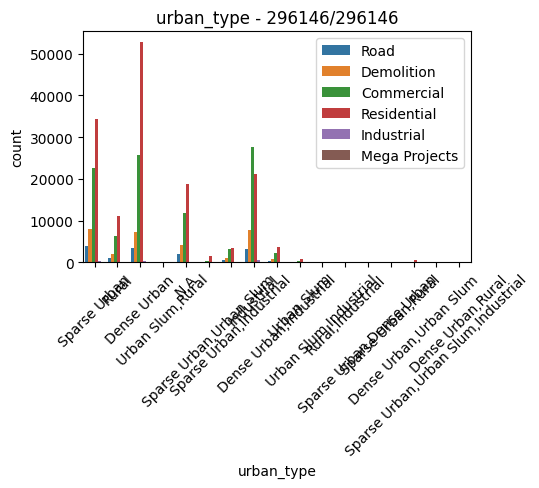

In [21]:
printInfos(train_df, "urban_type")

Let's collect all urban types

In [22]:
urban_types = set()
for df in [train_df, test_df]:
    for column in df["urban_type"].values:
        for urban_type in column.split(","):
            urban_types.add(urban_type)
print(urban_types)

{'N', 'Urban Slum', 'Rural', 'Dense Urban', 'Industrial', 'A', 'Sparse Urban'}


Given the small number of classes, we'll do one-hot encoding:

Let's create, for each urban type, a new column : urban_type_NAME

In [23]:
# For each urban_type
for urban_type in urban_types:
    
    # For each possible values in "urban_type", detecting if urban_type is inside
    label_to_result = dict()
    for df in [train_df, test_df]:
        for column in df["urban_type"].values:
            if urban_type in column.split(","):
                label_to_result[column] = 1
            else:
                label_to_result[column] = 0
    
    # Creating the new column urban_type_{NAME}
    new_col_name = f'urban_type_{urban_type}'.replace(' ', '')
    for df in [train_df, test_df]:
        df[new_col_name] = df["urban_type"].map(label_to_result)


Actually N,A takes always the same value: maybe N,A means that the value is missing.

We can drop urban_type_A, and rename urban_type_N to urban_type_N,A

In [24]:
# Removing urban_type_A, since it is the same as urban_type_N
for df in [train_df, test_df]:
    df.drop('urban_type_A', axis=1, inplace=True)
    df.rename(columns={'urban_type_N':'urban_type_N,A'}, inplace=True)

Here is the proportion of urban_type for each change_type

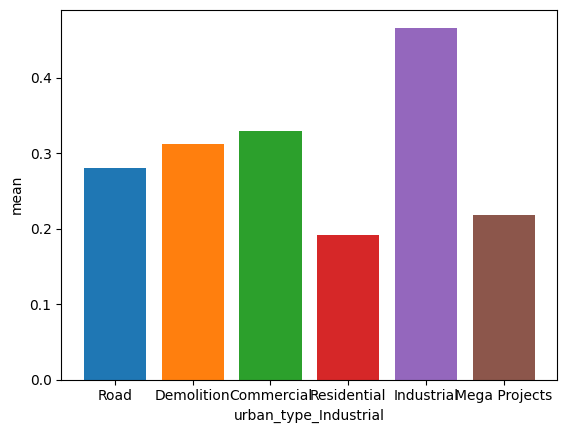

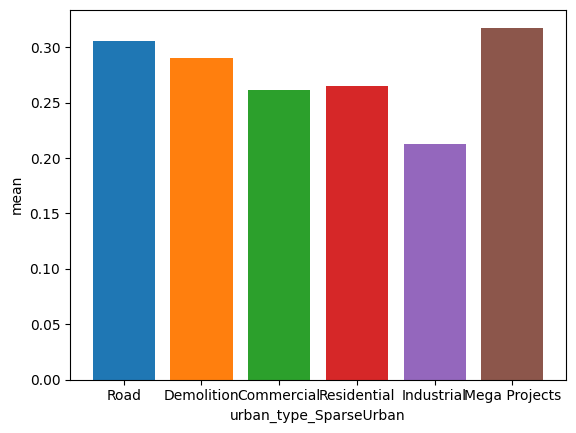

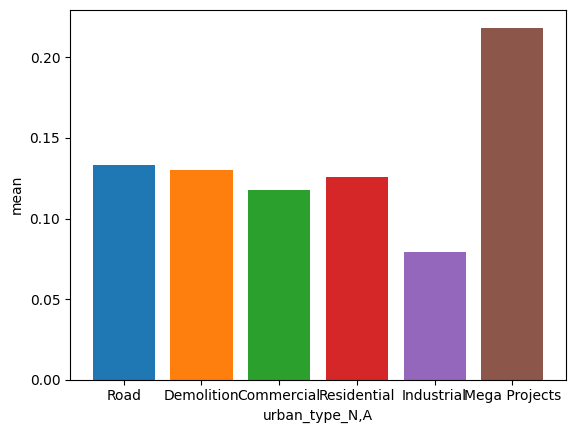

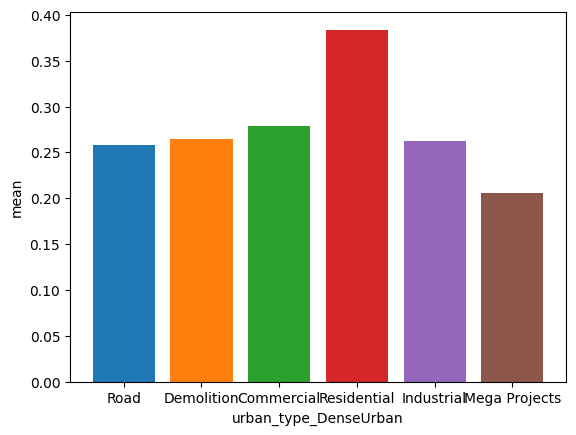

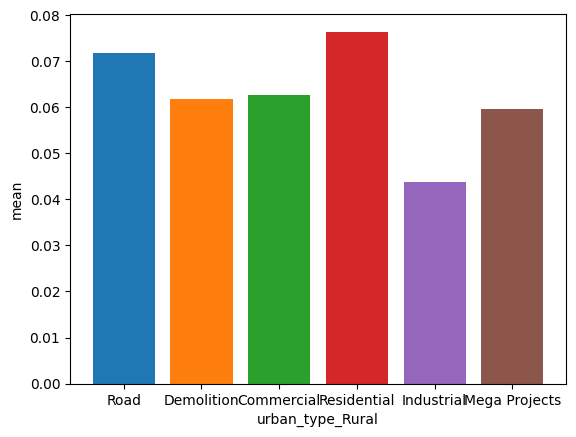

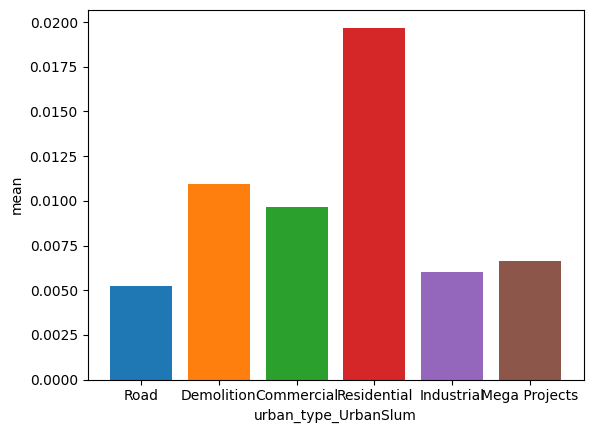

In [25]:
for newCol in ["urban_type_Industrial","urban_type_SparseUrban","urban_type_N,A","urban_type_DenseUrban","urban_type_Rural","urban_type_UrbanSlum"]:
    plotOneHot(train_df, newCol)

Since there are not so many combinations, we can also create one-hot-encoding for them:

In [26]:
combis = set()
for column in train_df["urban_type"].value_counts()[:10].index:
    if len(column.split(",")) > 1:
        combis.add(column)
combis

{'Dense Urban,Industrial',
 'Dense Urban,Urban Slum',
 'N,A',
 'Sparse Urban,Industrial',
 'Sparse Urban,Urban Slum'}

In [27]:
for df in [train_df, test_df]:
    for combi in combis:
        df[f'urban_type_{combi}'] = (df['urban_type']==combi).astype(float)

Here are the proportion for each class:

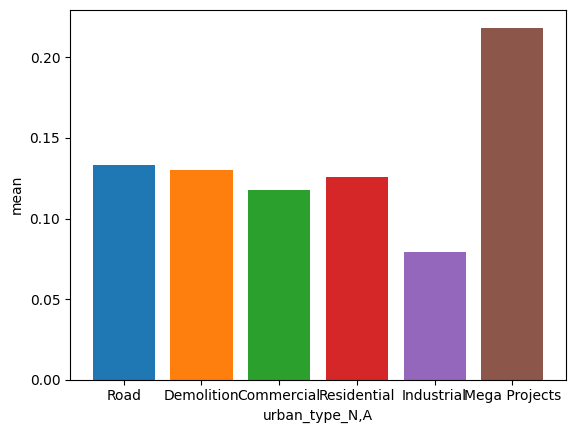

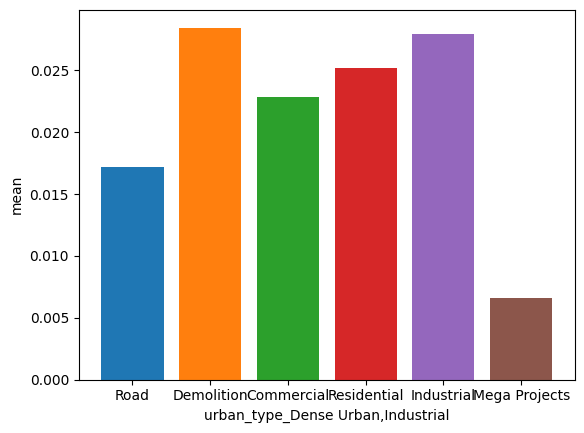

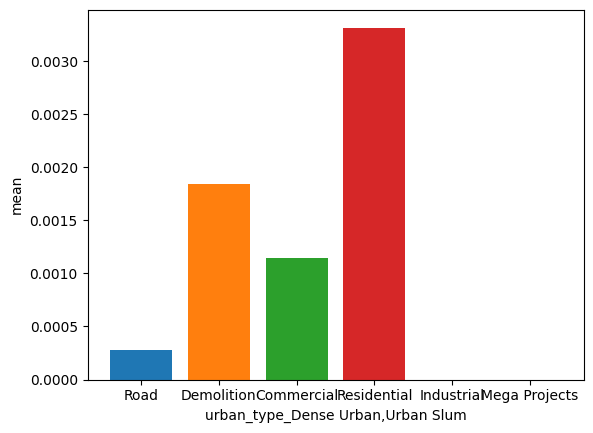

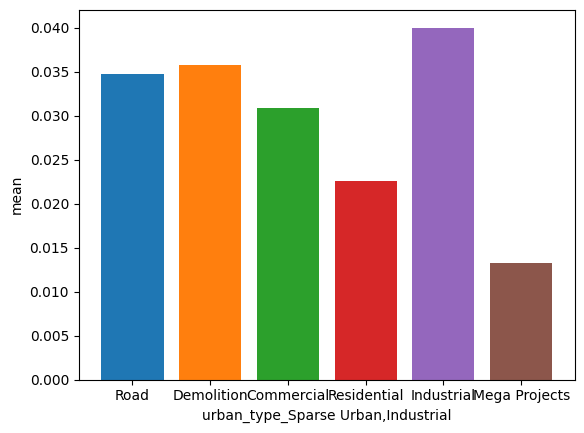

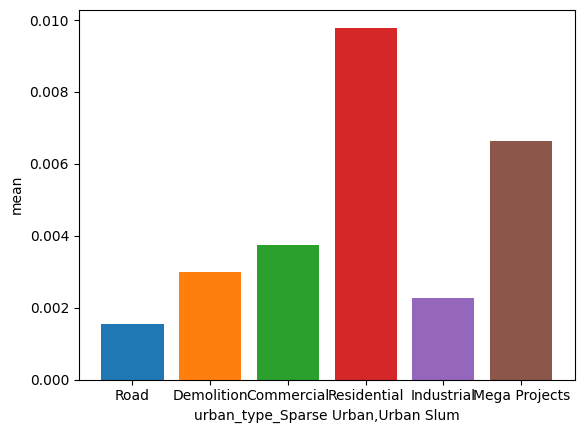

In [28]:
for combi in combis:
    plotOneHot(train_df, f'urban_type_{combi}')

<h2>4) Column: geography_type</h2>

This column contains also categorical data about the geography.

=== geography_type ===
Type : object
Missing values (NaN) : 0 / 296146
Nb of different values : 180
=== Value counts ===
Sparse Forest,Grass Land                              43834
Sparse Forest                                         31036
Sparse Forest,Farms                                   16765
Sparse Forest,Dense Forest,Grass Land                 16457
Barren Land,Sparse Forest                             13573
                                                      ...  
Sparse Forest,Lakes,Snow                                  1
River,Sparse Forest,Dense Forest,Farms,Hills,Lakes        1
Coastal,Sparse Forest,Grass Land,Hills,Desert             1
River,Barren Land,Dense Forest,Grass Land,Farms           1
Sparse Forest,Grass Land,Hills,Lakes                      1
Name: geography_type, Length: 180, dtype: int64
=== Data description ===
count                       296146
unique                         180
top       Sparse Forest,Grass Land
freq                         43834
Name: 

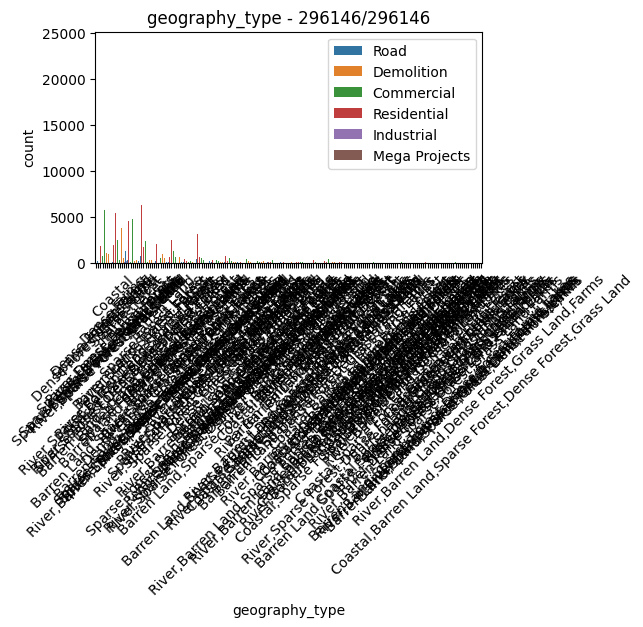

In [29]:
printInfos(train_df, "geography_type")

This time, there are much more geography mixes observed

Let's collect all possible geography types

In [30]:
# Detecting all geography types
geography_types = set()
for df in [train_df, test_df]:
    for column in df["geography_type"].values:
        for geography_type in column.split(","):
            geography_types.add(geography_type)
print(geography_types)

{'N', 'Desert', 'Farms', 'Dense Forest', 'Hills', 'River', 'Grass Land', 'Snow', 'Lakes', 'Barren Land', 'Coastal', 'Sparse Forest', 'A'}


And let's do one-hot encoding

In [31]:
# Creating new columns
for geography_type in geography_types:
    label_to_result = dict()
    for df in [train_df, test_df]:
        for column in df["geography_type"].values:
            if geography_type in column.split(","):
                label_to_result[column] = 1
            else:
                label_to_result[column] = 0
    
    new_col_name = f'geography_type_{geography_type}'.replace(' ', '')
    for df in [train_df, test_df]:
        df[new_col_name] = df["geography_type"].map(label_to_result)


We can plot the proportion of each geography_type

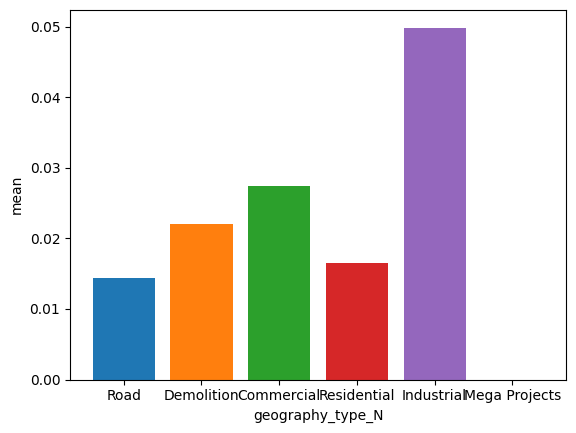

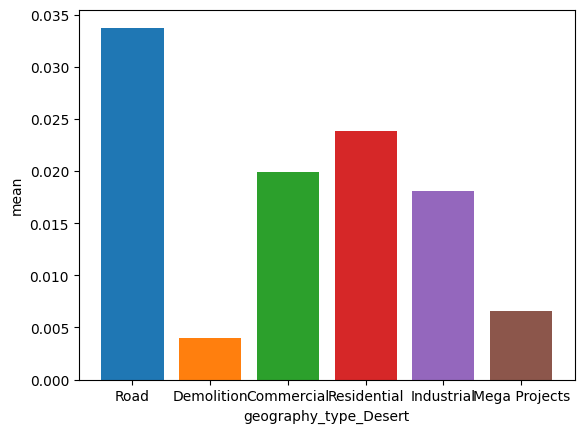

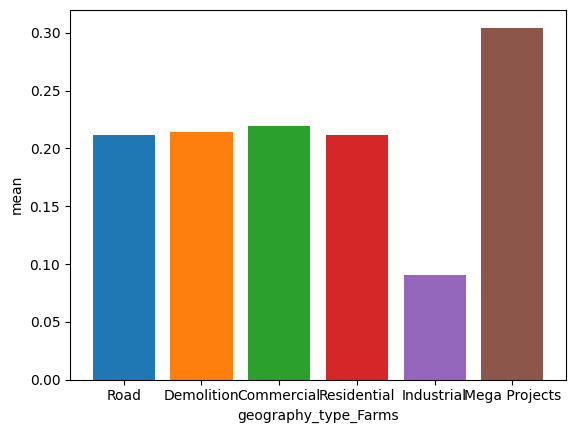

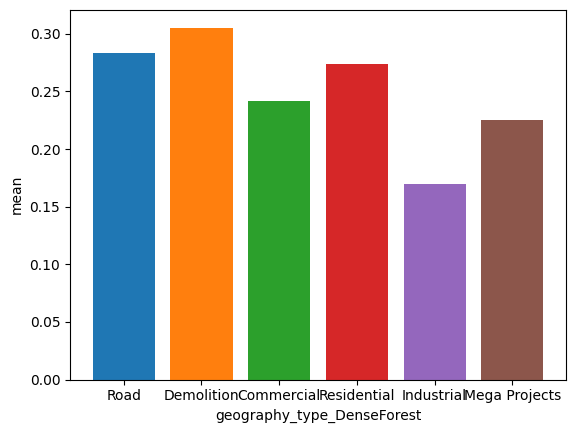

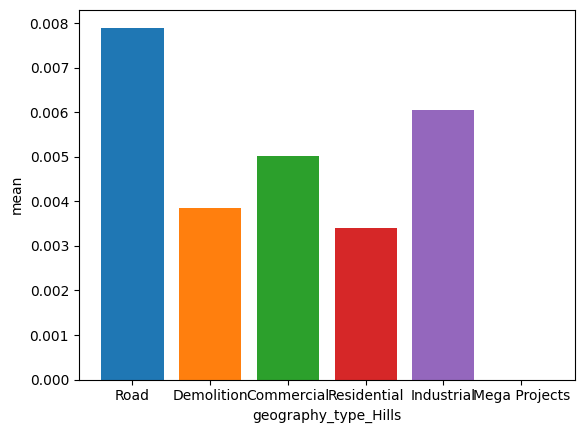

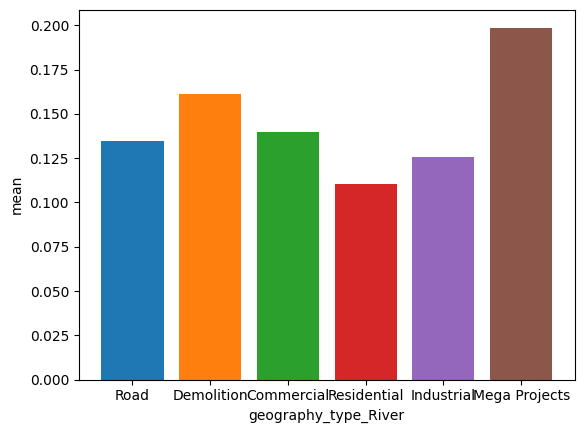

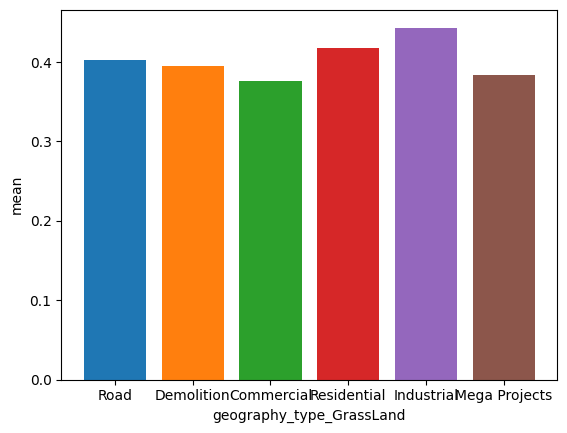

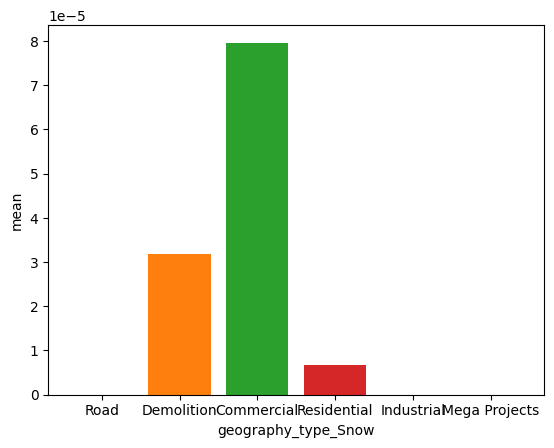

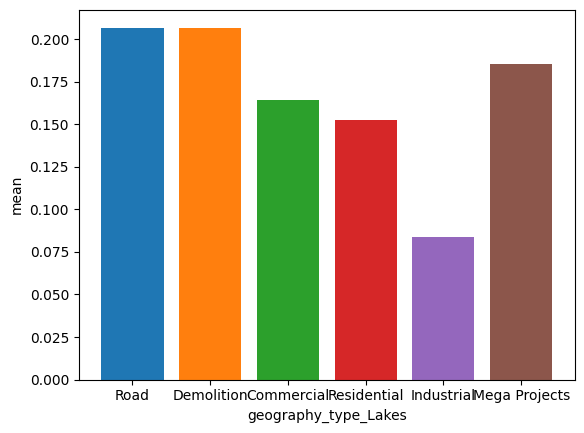

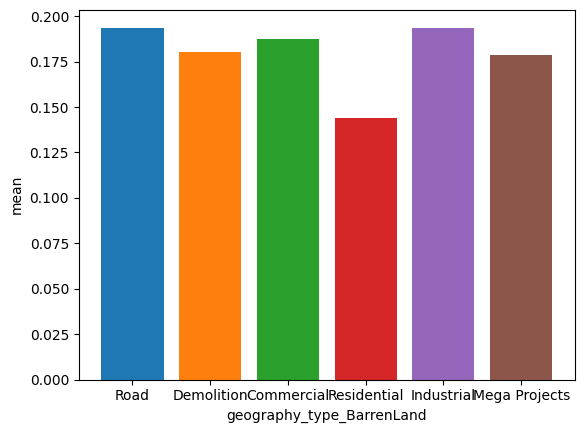

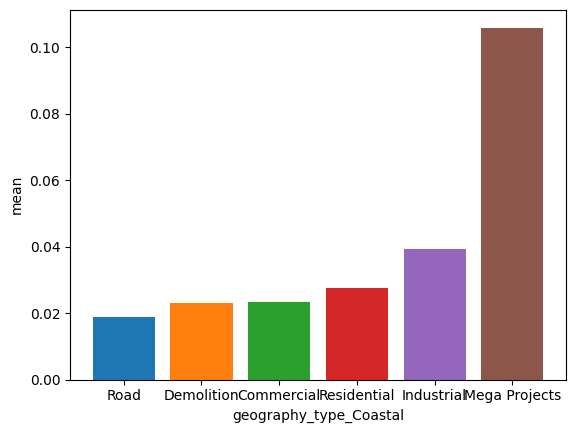

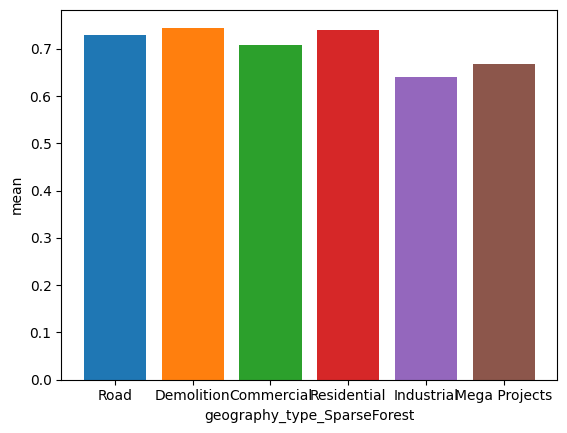

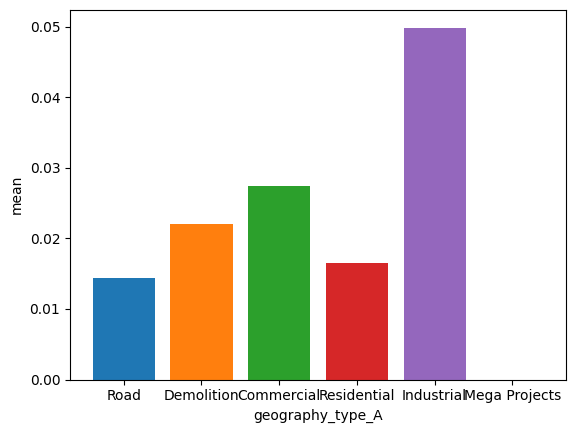

In [32]:
for newCol in[f'geography_type_{t}'.replace(' ', '') for t in geography_types]:
    plotOneHot(train_df, newCol)

We group N,A

In [33]:
for df in [train_df, test_df]:
    df.drop('geography_type_A', axis=1, inplace=True)
    df.rename(columns={'geography_type_N':'geography_type_N,A'}, inplace=True)

We'll do one-hot-encoding for mixes of geography_types only for the most encountered values:

In [34]:
train_df["geography_type"].value_counts()[:20]

Sparse Forest,Grass Land                       43834
Sparse Forest                                  31036
Sparse Forest,Farms                            16765
Sparse Forest,Dense Forest,Grass Land          16457
Barren Land,Sparse Forest                      13573
Barren Land                                    11014
Sparse Forest,Dense Forest                     10916
Dense Forest                                    9125
Farms                                           8764
Sparse Forest,Grass Land,Lakes                  8092
Sparse Forest,Farms,Lakes                       7801
River,Sparse Forest,Grass Land                  7774
N,A                                             6183
Grass Land                                      5812
Desert                                          5453
River,Sparse Forest                             4663
Sparse Forest,Dense Forest,Grass Land,Lakes     4521
Barren Land,Sparse Forest,Grass Land            4157
Dense Forest,Grass Land                       

In [35]:
combis = []
for col in train_df["geography_type"].value_counts()[:20].index:
    if len(col.split(",")) > 1:
        combis.append(col)
    if len(combis) > 15:
        break
combis


['Sparse Forest,Grass Land',
 'Sparse Forest,Farms',
 'Sparse Forest,Dense Forest,Grass Land',
 'Barren Land,Sparse Forest',
 'Sparse Forest,Dense Forest',
 'Sparse Forest,Grass Land,Lakes',
 'Sparse Forest,Farms,Lakes',
 'River,Sparse Forest,Grass Land',
 'N,A',
 'River,Sparse Forest',
 'Sparse Forest,Dense Forest,Grass Land,Lakes',
 'Barren Land,Sparse Forest,Grass Land',
 'Dense Forest,Grass Land',
 'River,Sparse Forest,Farms']

In [36]:
for df in [train_df, test_df]:
    for combi in combis:
        df[f'geography_type_{combi}'] = (df['geography_type'] == combi).astype(float)

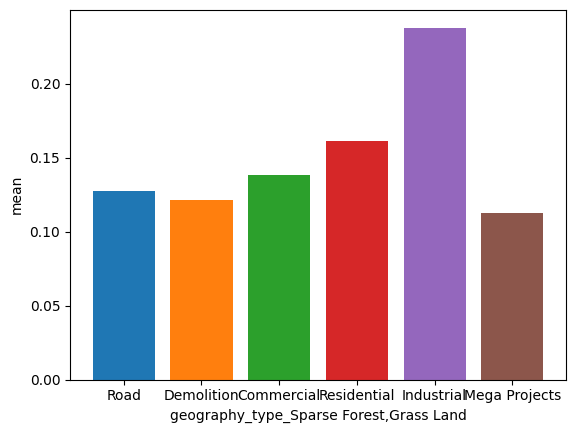

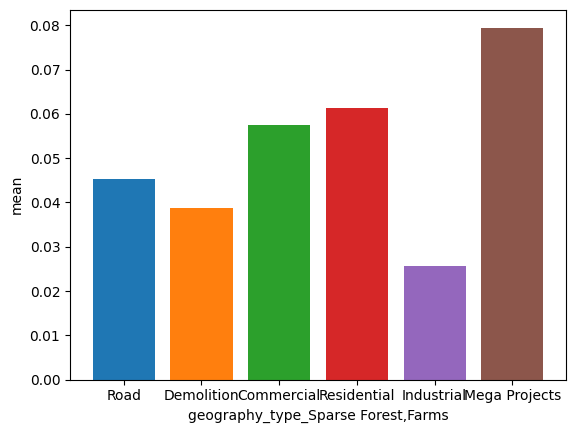

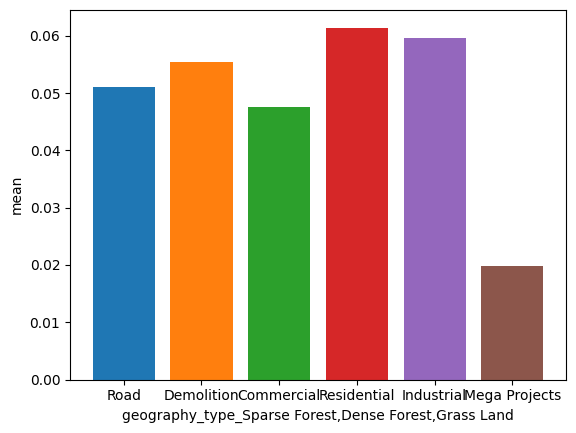

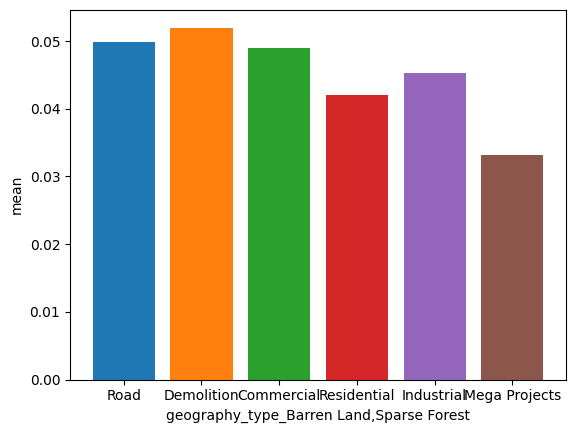

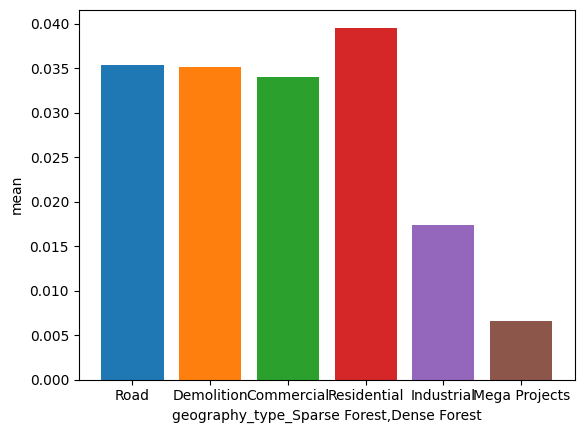

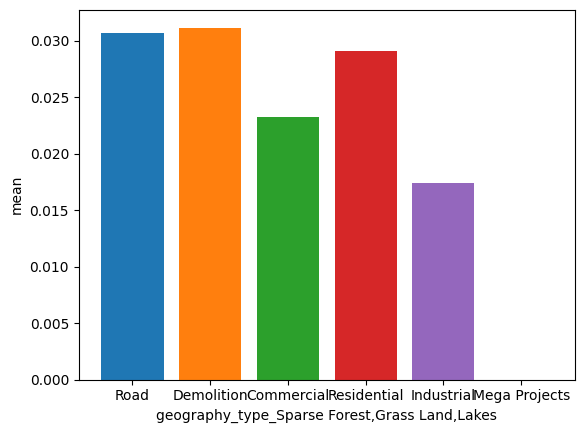

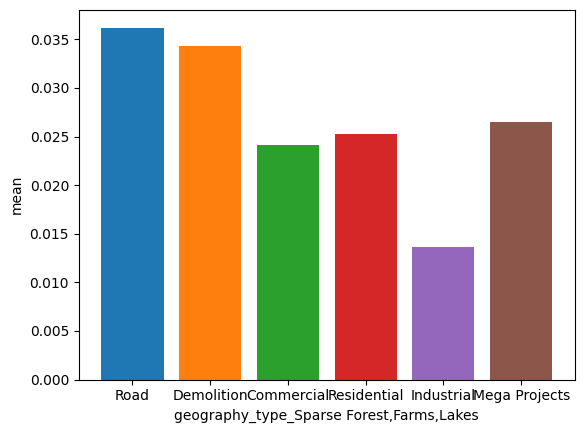

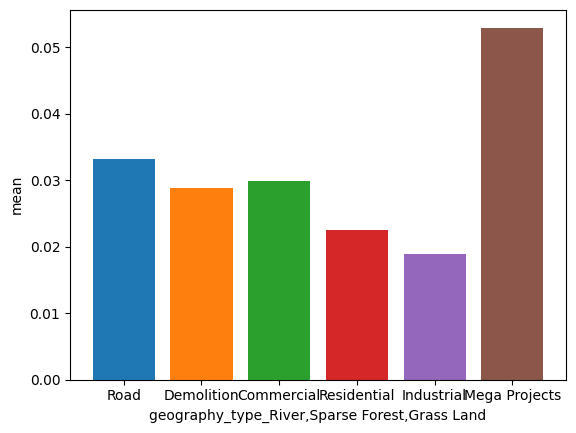

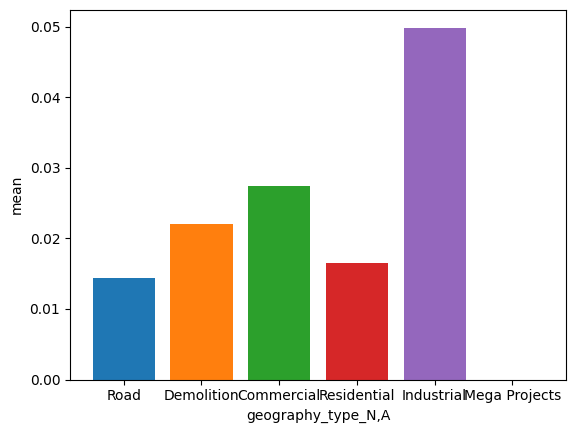

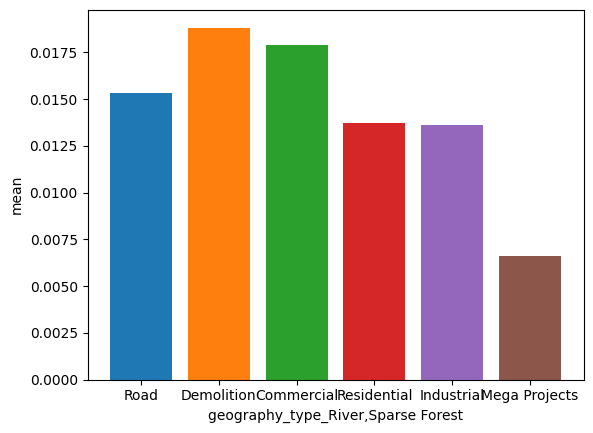

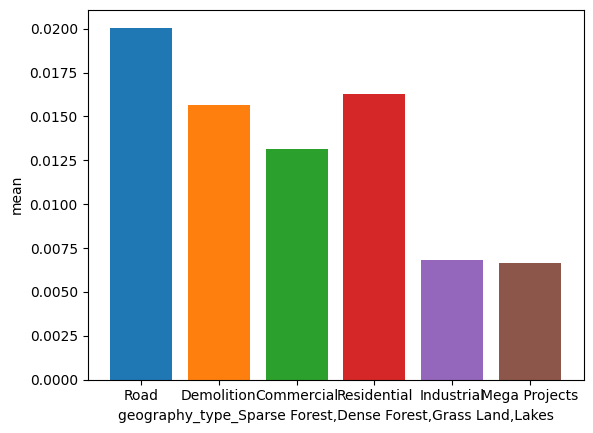

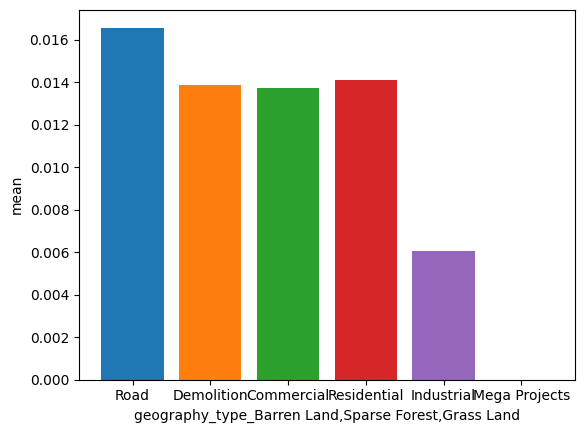

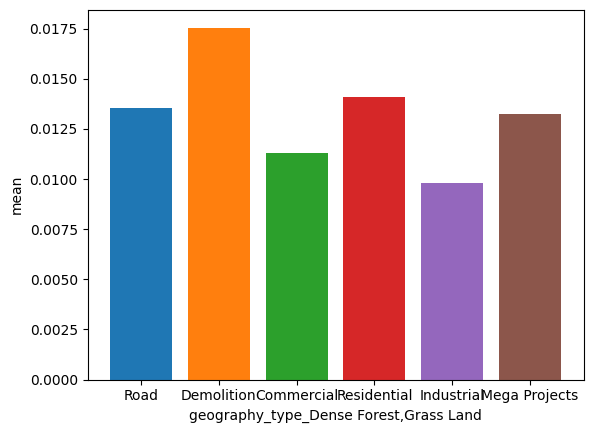

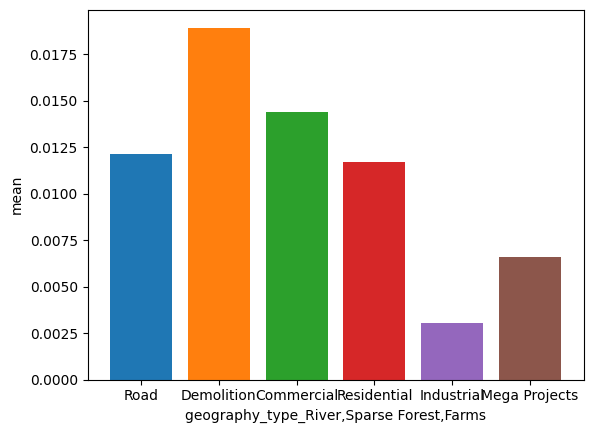

In [37]:
for combi in combis:
    plotOneHot(train_df, f'geography_type_{combi}')

<h2>5) Column: geo_urban</h2>

Maybe combine geography_type and urban_type ?

We keep only the mixes that contains more that 1% of a change_type

geography_type_Desert


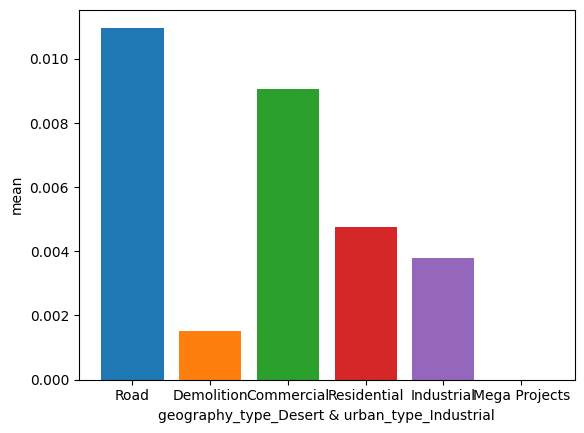

geography_type_Farms


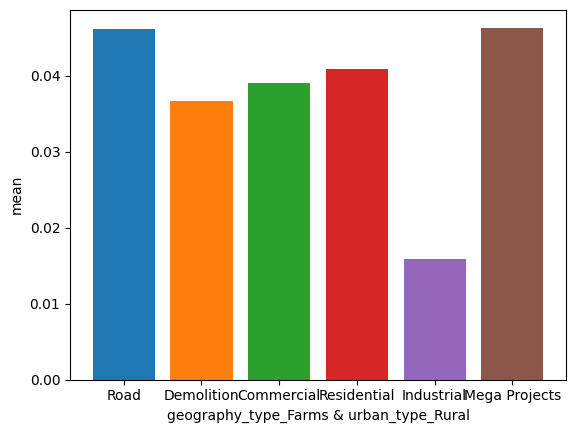

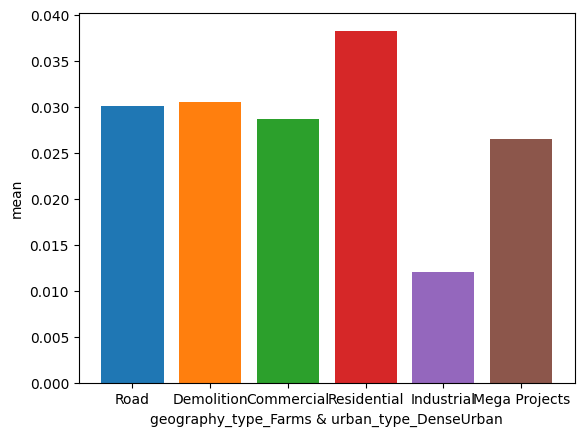

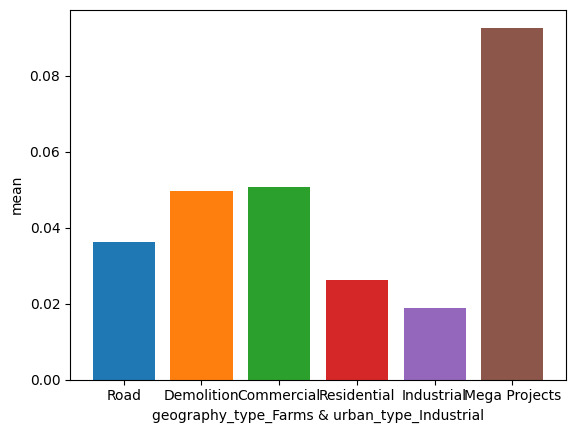

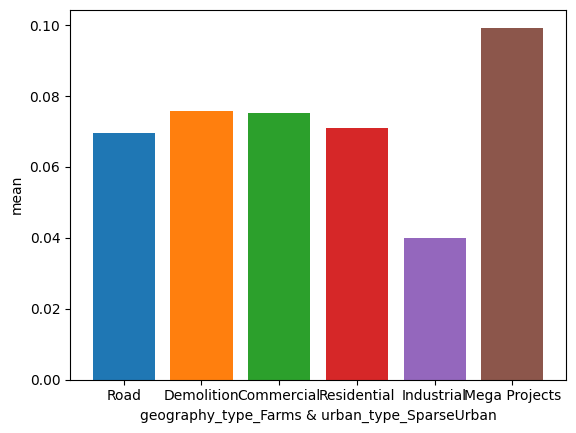

geography_type_DenseForest


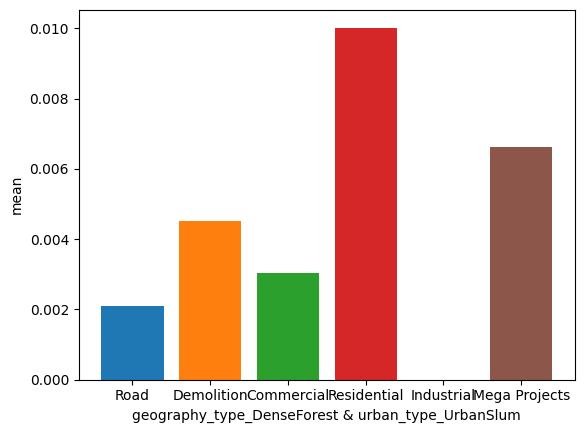

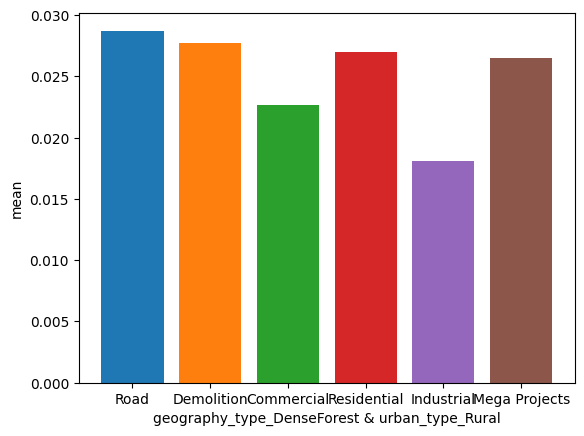

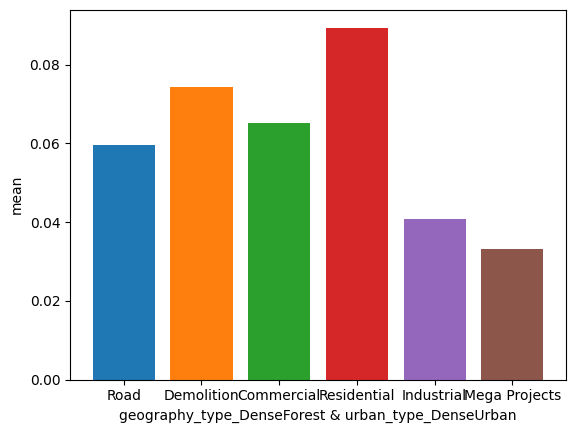

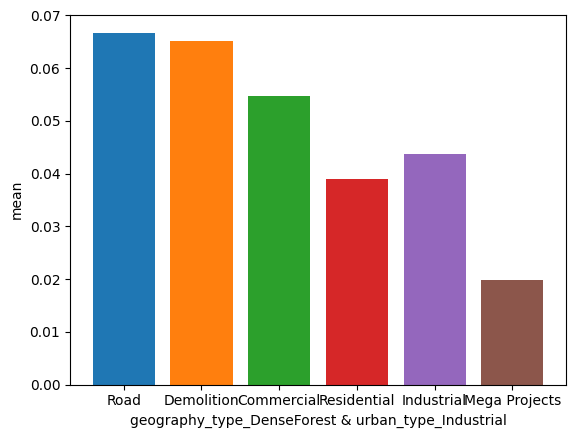

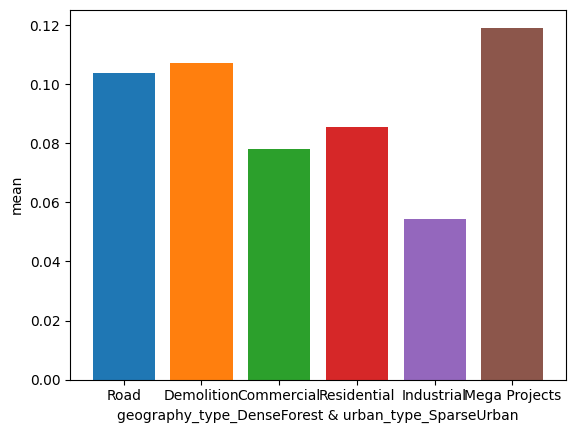

geography_type_Hills
geography_type_River


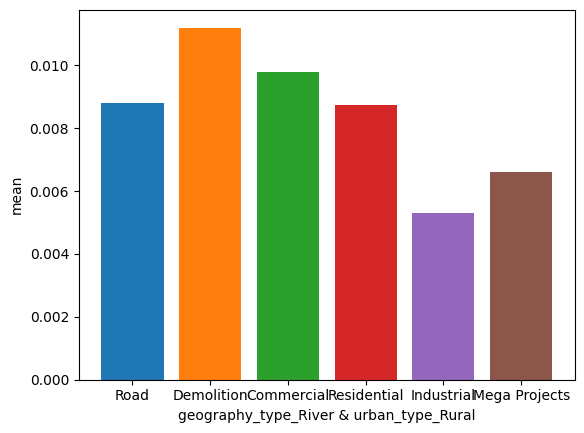

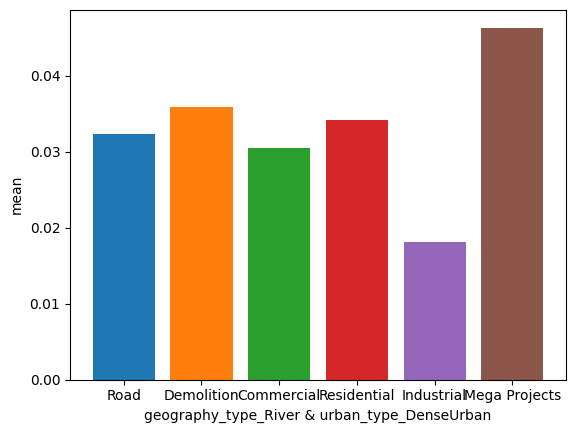

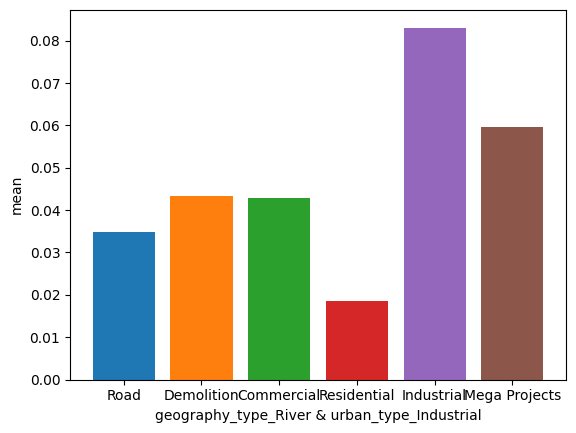

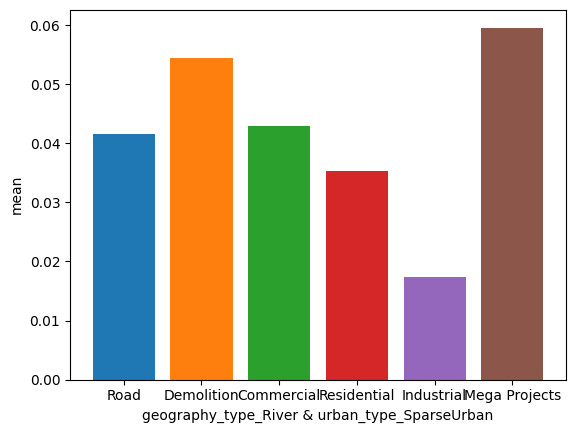

geography_type_GrassLand


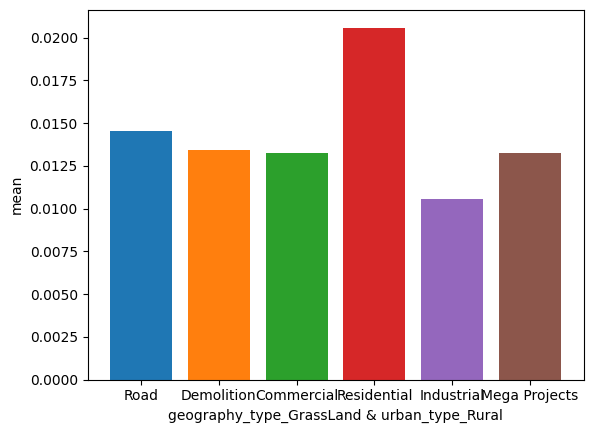

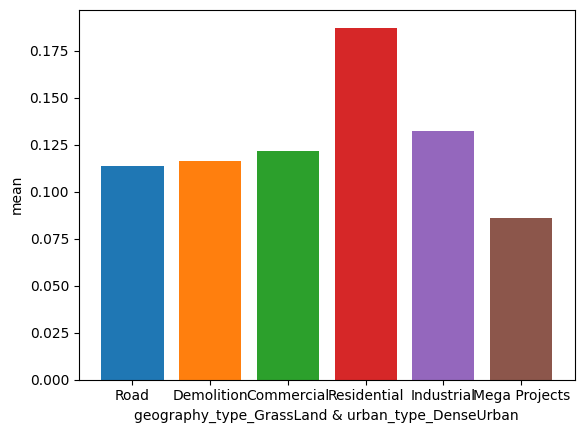

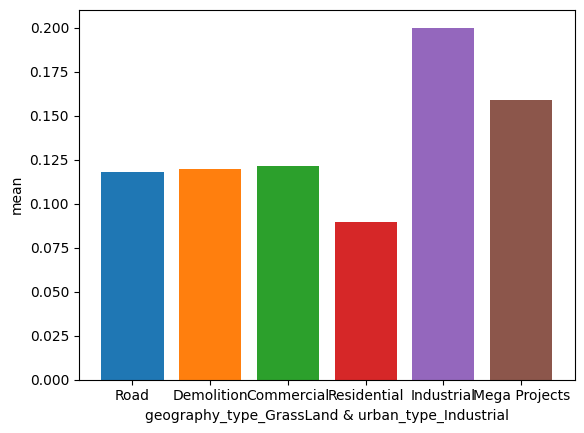

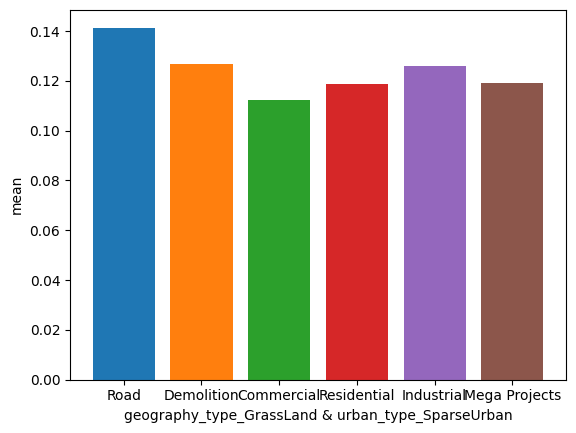

geography_type_Snow
geography_type_Lakes


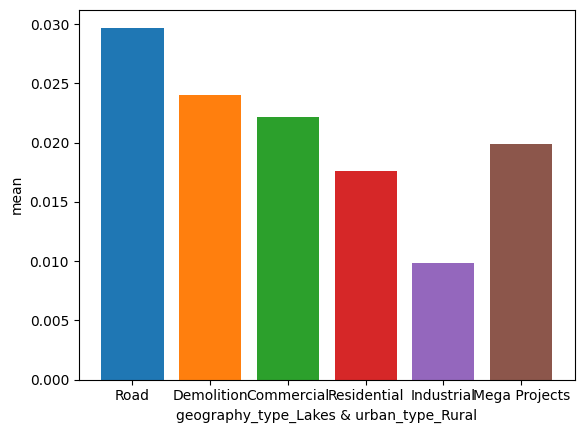

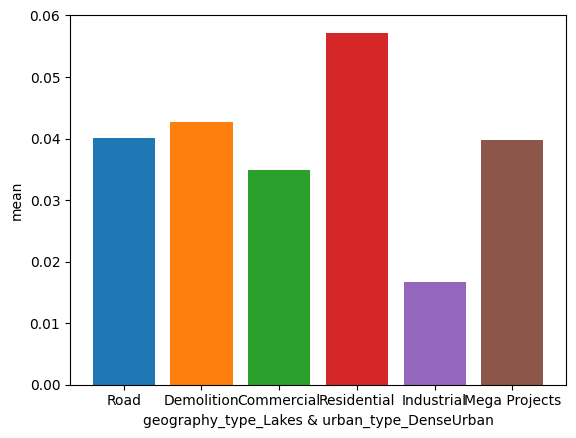

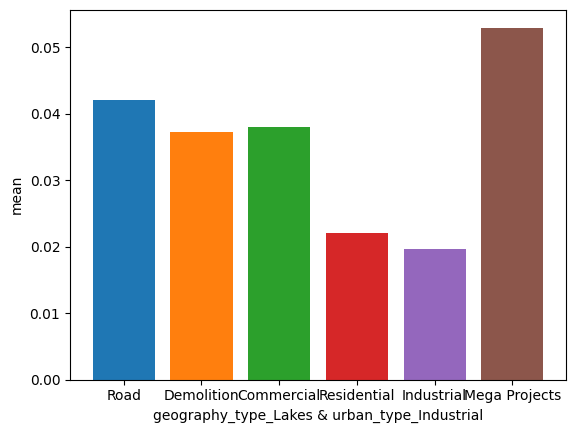

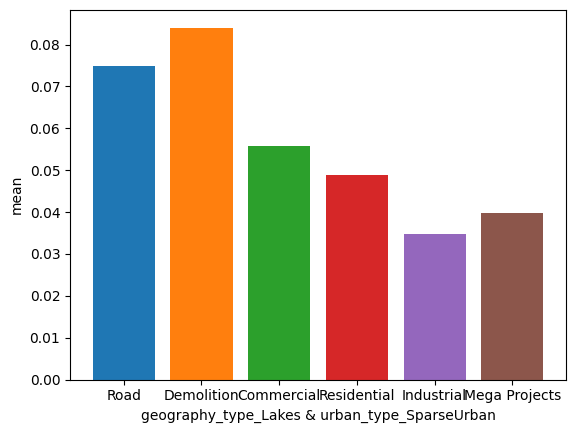

geography_type_BarrenLand


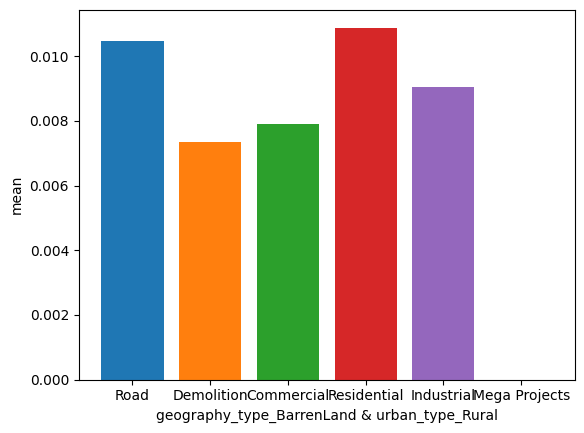

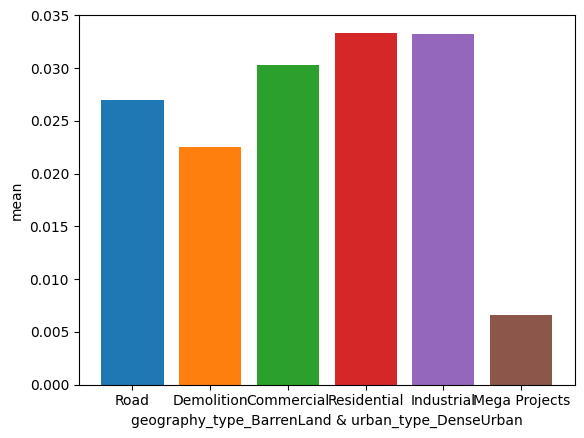

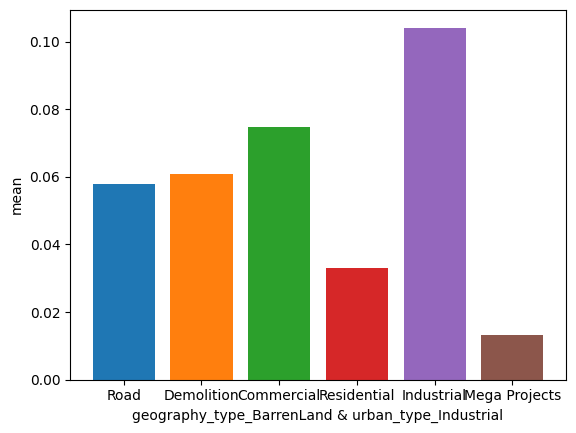

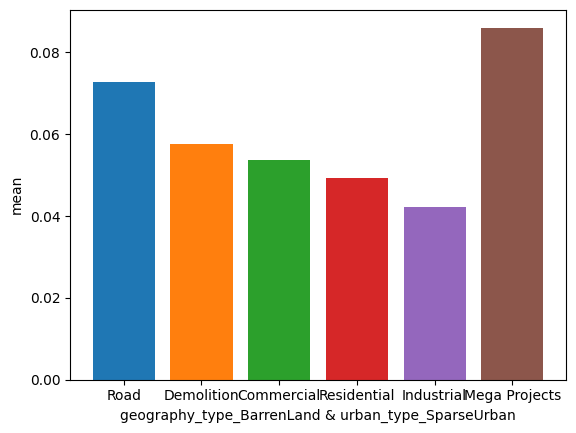

geography_type_Coastal


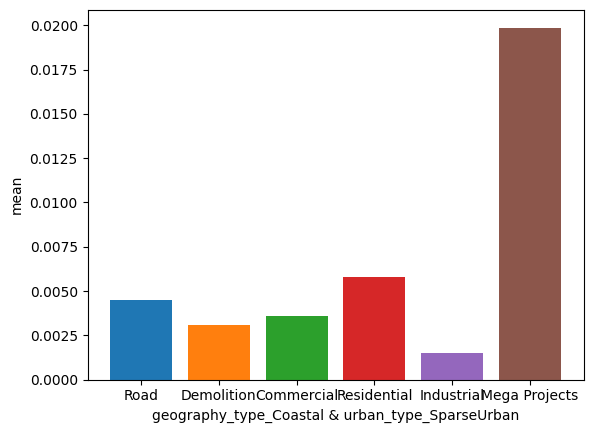

geography_type_SparseForest


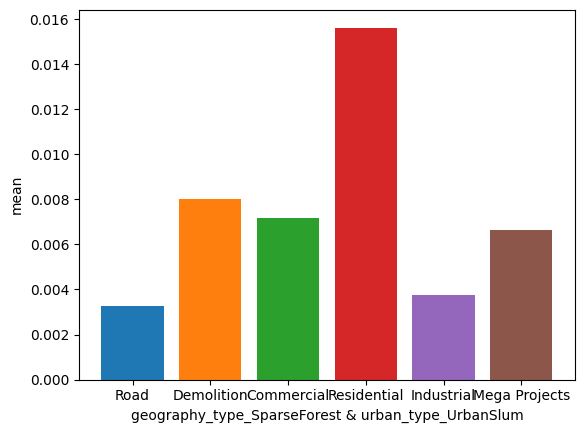

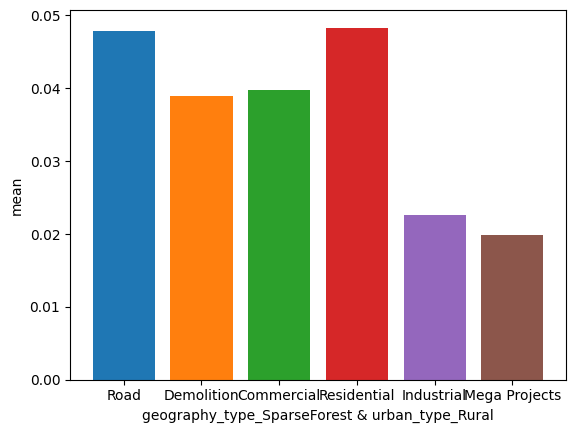

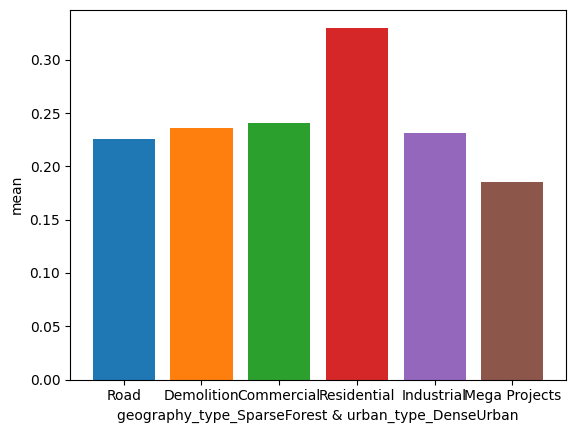

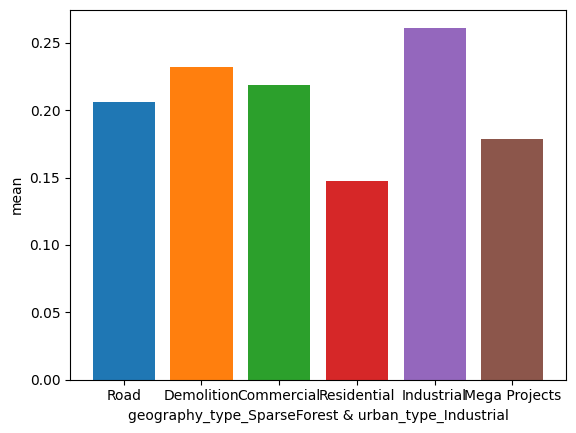

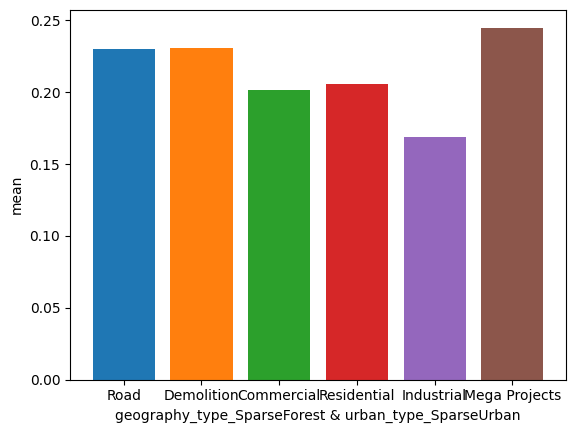

In [38]:
combisGeoUrban = []
for column1 in train_df.columns:
    if not column1.startswith("geography_type") or len(column1.split(",")) != 1 or column1 == "geography_type":
        continue
    print(column1)
    for column2 in train_df.columns:
        if not column2.startswith("urban_type") or len(column2.split(",")) != 1 or column2 == "urban_type":
            continue

        #maxVal corresponds to the maximum proportion observed in a change_type, for a given geography_type column1 and urban_type column2    
        maxVal = -np.inf
        for change_type in train_df["change_type"].unique():
            maxVal = max(maxVal, (train_df[train_df["change_type"]==change_type][column1]*train_df[train_df["change_type"]==change_type][column2]).mean())
        if maxVal > 0.01:
            plotOneHotDouble(train_df, column1, column2)
            for df in [train_df, test_df]:
                df[f'geourban_{column1}_{column2}'] = df[column1]*df[column2]

In [39]:
nb = 0
for column in train_df.columns:
    if column.startswith("geourban"):
        nb+=1
print("NB geourban created:", nb)

NB geourban created: 32


<h2>6) Sorting Dates</h2>

First, some columns are labeled from 0 to 4, others from 1 to 5. Let's fix that

In [40]:
# renaming all dates related columns
for df in [train_df, test_df]:
    for i in range(5):
        df[f"date{i}"] = pd.to_datetime(df[f"date{i}"], format="%d-%m-%Y")
        df.rename(columns={f"date{i}": f"date{i}_old",
                           f"img_red_mean_date{i+1}": f"img_red_mean_date{i}_old",
                           f"img_green_mean_date{i+1}": f"img_green_mean_date{i}_old",
                           f"img_blue_mean_date{i+1}": f"img_blue_mean_date{i}_old",
                           f"img_red_std_date{i+1}": f"img_red_std_date{i}_old",
                           f"img_green_std_date{i+1}": f"img_green_std_date{i}_old",
                           f"img_blue_std_date{i+1}": f"img_blue_std_date{i}_old",
                           f"change_status_date{i}": f"change_status_date{i}_old"}, inplace=True)

Moreover, let's look at our dates...

In [41]:
train_df[[f"date{i}_old" for i in range(5)]].head()

date0_old  date1_old  date2_old  date3_old  date4_old
0 2018-08-01 2013-12-09 2016-09-10 2019-07-22 2017-07-24
1 2018-08-01 2013-12-09 2016-09-10 2019-07-22 2017-07-24
2 2018-08-01 2013-12-09 2016-09-10 2019-07-22 2017-07-24
3 2018-08-01 2013-12-09 2016-09-10 2019-07-22 2017-07-24
4 2018-08-01 2013-12-09 2016-09-10 2019-07-22 2017-07-24

date0, date1, ... date4 are actually not sorted chronologically! We fix that here:

In [42]:
# Toutes les colonnes qu'on doit réorganiser
col_prefixes = ["img_red_mean_date", "img_green_mean_date", "img_blue_mean_date", "img_red_std_date", "img_green_std_date", "img_blue_std_date", "change_status_date", "date"]

for df in [train_df, test_df]:
    # df avec les dates
    dftemp=df[[f"date{i}_old" for i in range(5)]].replace(np.nan, pd.to_datetime("01-01-1970", format="%d-%m-%Y"))
    
    # Tableau numpy tq new_to_old[iLigne, nouvelleDate] = ancienneDate
    new_to_old = np.argsort(dftemp.values, axis=1)

    for col_prefix in col_prefixes:
        for iNewDate in range(5):
            # Ajout d'une nouvelle ligne
            newColName = f"{col_prefix}{iNewDate}"
            df.insert(len(df.columns), newColName, None)
            for iOldDate in range(5):
                oldColName = f"{col_prefix}{iOldDate}_old"
                # Pour chaque ancienne date correspondante, on met à jour
                df.loc[(new_to_old[df.index, iNewDate] == iOldDate), newColName] = df.loc[(new_to_old[df.index, iNewDate] == iOldDate), oldColName]
    

In [43]:
# Converting back to float / datetime
col_imgs = ["img_red_mean_date", "img_green_mean_date", "img_blue_mean_date", "img_red_std_date", "img_green_std_date", "img_blue_std_date"]
for df in [train_df, test_df]:
    for col in col_imgs:
        for i in range(5):
            col_name = f"{col}{i}"
            df[col_name] = df[col_name].astype(float)
    for iDate in range(5):
        col_name = f'date{iDate}'
        df[col_name] = pd.to_datetime(df[col_name])

Let's see if it's ok now:

In [44]:
train_df[[f"date{i}" for i in range(5)]].head()

date0      date1      date2      date3      date4
0 2013-12-09 2016-09-10 2017-07-24 2018-08-01 2019-07-22
1 2013-12-09 2016-09-10 2017-07-24 2018-08-01 2019-07-22
2 2013-12-09 2016-09-10 2017-07-24 2018-08-01 2019-07-22
3 2013-12-09 2016-09-10 2017-07-24 2018-08-01 2019-07-22
4 2013-12-09 2016-09-10 2017-07-24 2018-08-01 2019-07-22

We can now remove the old unsorted columns

In [45]:
colRemove = []
for oldCol in col_prefixes:
    for iDate in range(5):
        colRemove.append(f'{oldCol}{iDate}_old')
for df in [train_df, test_df]:
    df.drop(columns=colRemove, inplace=True)

<h2>7) Change Status</h2>

=== change_status_date0 ===
Type : object
Missing values (NaN) : 0 / 296146
Nb of different values : 10
=== Value counts ===
Land Cleared            93430
Prior Construction      87436
Greenland               81182
Construction Midway     15149
Construction Started     7987
Materials Dumped         5072
Materials Introduced     2577
Construction Done        1856
Operational               896
Excavation                561
Name: change_status_date0, dtype: int64
=== Data description ===
count           296146
unique              10
top       Land Cleared
freq             93430
Name: change_status_date0, dtype: object


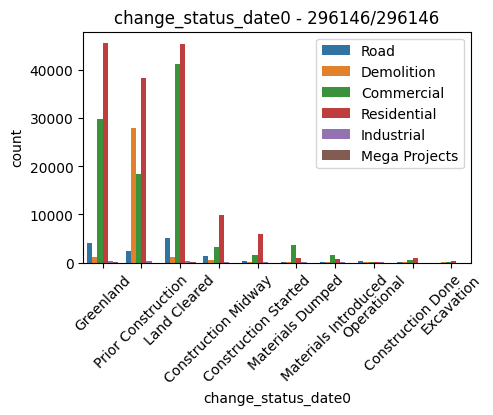

In [46]:
printInfos(train_df, "change_status_date0")

We can create dummy variables

In [47]:
new_dummies = pd.get_dummies(train_df[[f"change_status_date{i}" for i in range(5)]], dtype=float)
train_df = pd.concat([train_df, new_dummies], axis=1)

new_dummies = pd.get_dummies(test_df[[f"change_status_date{i}" for i in range(5)]], dtype=float)
test_df = pd.concat([test_df, new_dummies], axis=1)

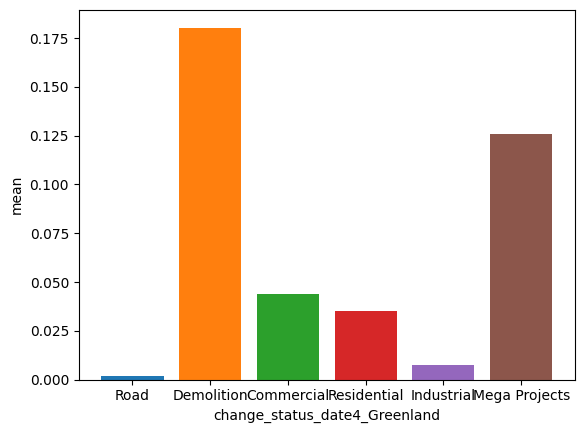

In [48]:
plotOneHot(train_df, "change_status_date4_Greenland")

Let's compute the sums, regardless of the date

In [49]:
change_status_map = {
    "Prior Construction": 0,
    "Greenland": 1,
    "Land Cleared": 2,
    "Excavation": 3,
    "Materials Dumped": 4,
    "Materials Introduced": 5,
    "Construction Started": 6,
    "Construction Midway": 7,
    "Construction Done": 8,
    "Operational": 9,
}

In [50]:
for df in [train_df, test_df]:
    for status in change_status_map:
        df[f"change_status_{status}"] = df[f"change_status_date0_{status}"]\
                                        +df[f"change_status_date1_{status}"]\
                                        +df[f"change_status_date2_{status}"]\
                                        +df[f"change_status_date3_{status}"]\
                                        +df[f"change_status_date4_{status}"]

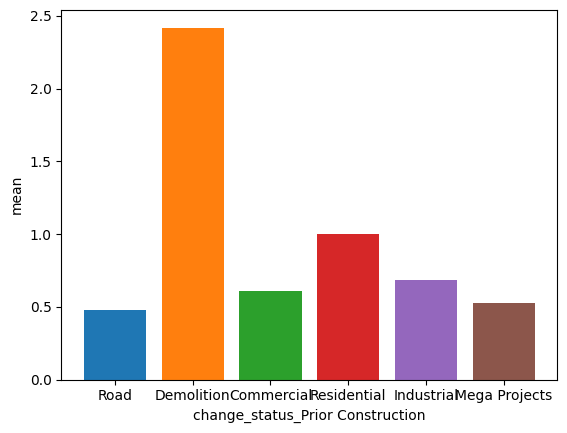

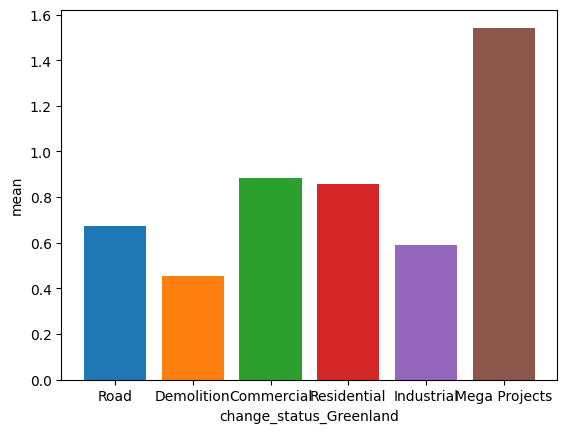

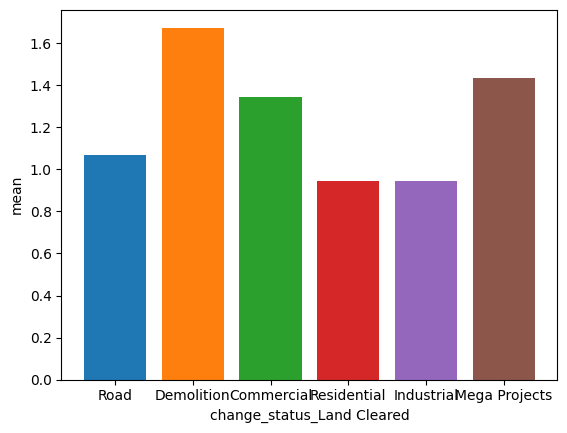

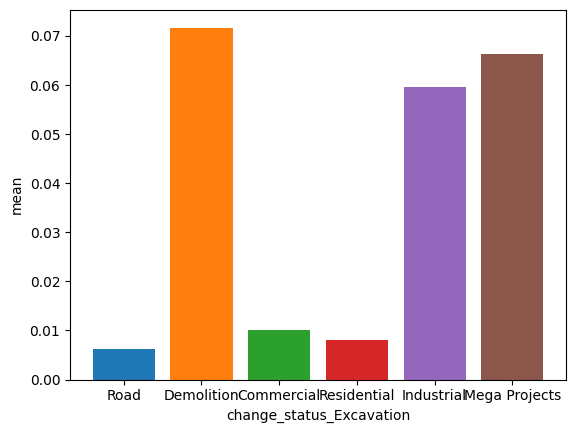

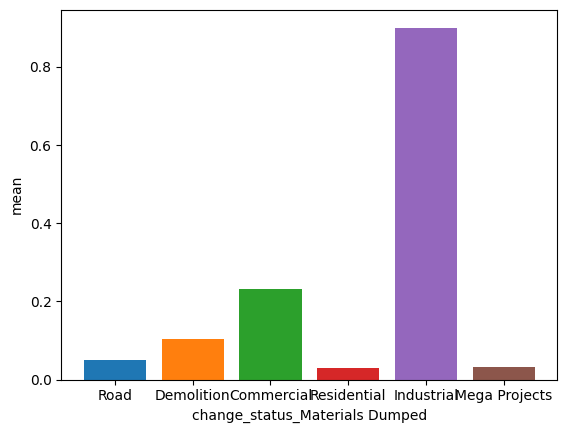

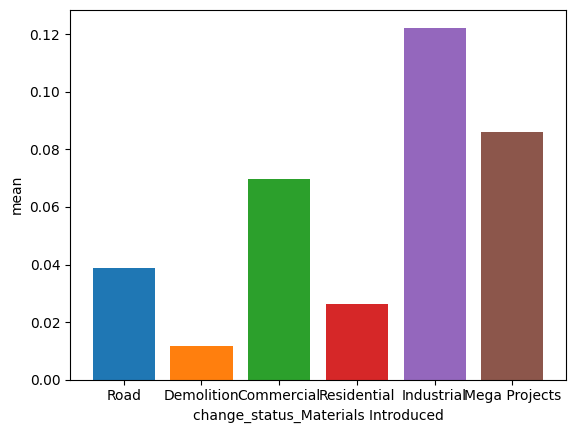

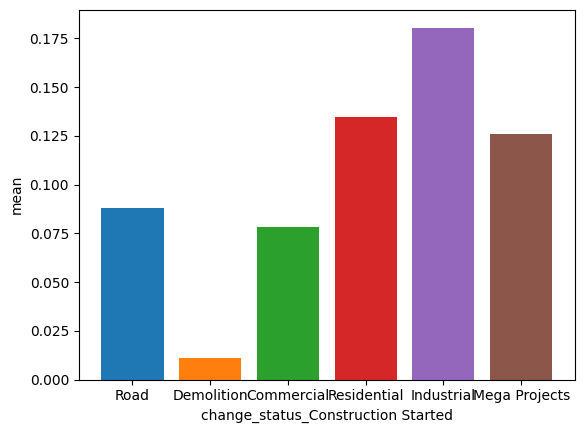

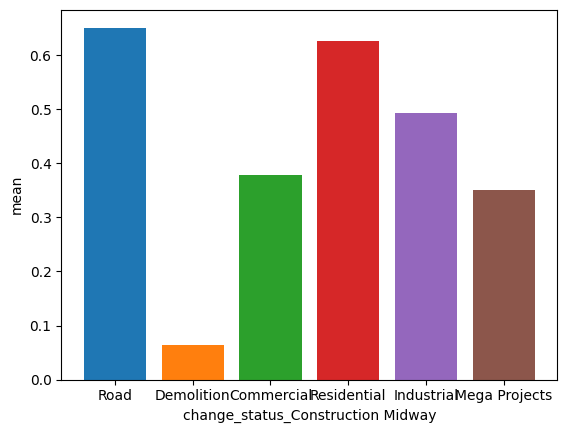

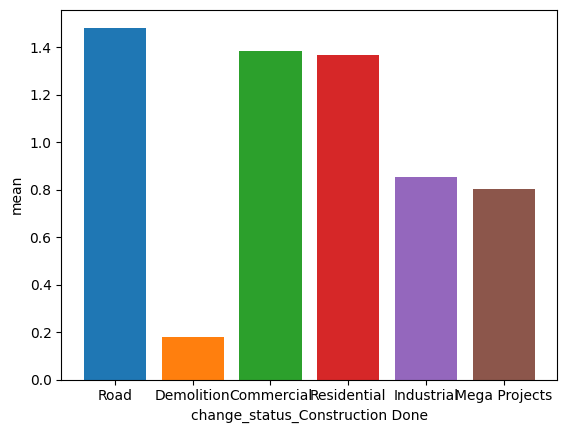

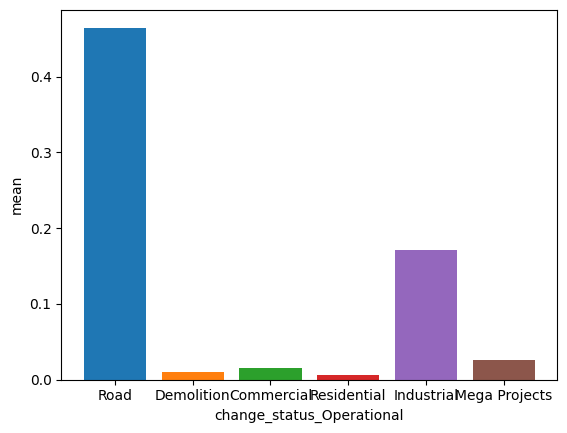

In [51]:
for status in change_status_map:
    plotOneHot(train_df, f'change_status_{status}')

<AxesSubplot:xlabel='change_type', ylabel='change_status_Greenland'>

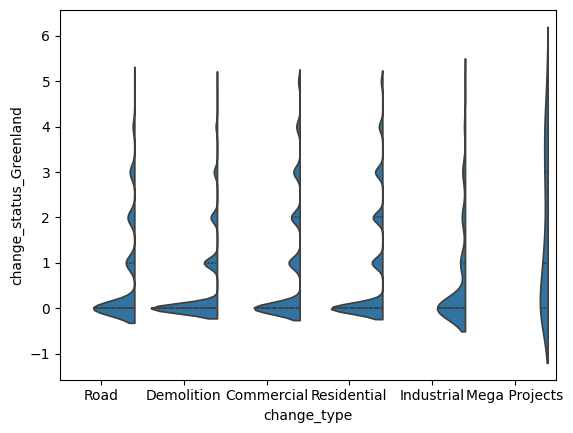

In [52]:
sns.violinplot(x="change_type", y="change_status_Greenland", hue=None, data=train_df, split=True, inner="quart")

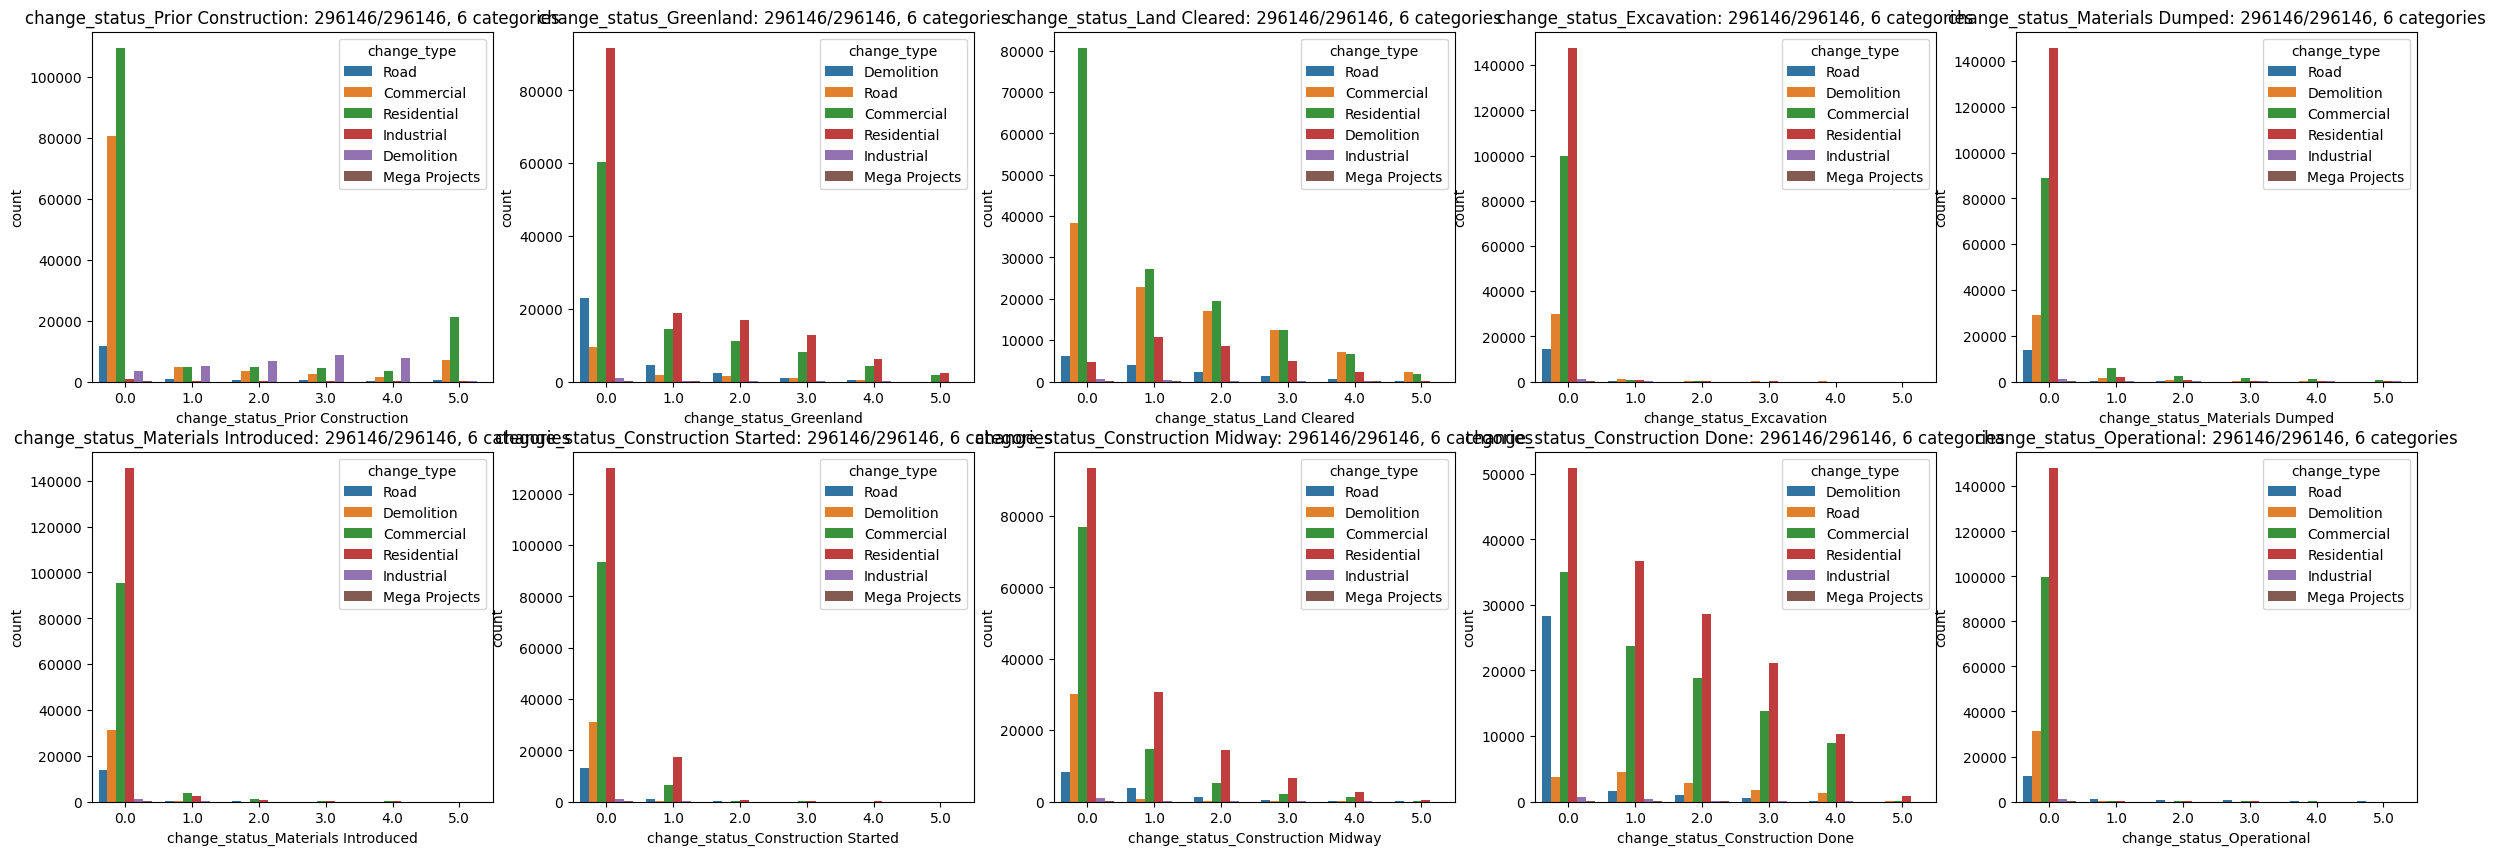

In [53]:
plotInfos(train_df, [f"change_status_{status}" for status in change_status_map])

We can compute all possible variations (10 x 10 new features !!)

In [54]:
"""
for df in [train_df, test_df]:
    for statusBegin in change_status_map:
        for statusEnd in change_status_map:
            df[f"change_status_{statusBegin}_{statusEnd}"] = 0
            for iDateDebut in range(4):
                df.loc[(df[f"change_status_date{iDateDebut}"] == statusBegin) & (df[f"change_status_date{iDateDebut+1}"] == statusEnd), f"change_status_{statusBegin}_{statusEnd}"] += 1
"""
""

''

We can also do an encoding based on our belief

In [55]:
# We suppose an order in change_status, which repose on our belief and might not be true.
for df in [train_df, test_df]:
    for iDate in range(5):
        df[f'change_status_date{iDate}_encoded'] = df[f'change_status_date{iDate}'].map(change_status_map)

We can also compute the variations

In [56]:
# Maybe adding end - beginning ?
for df in [train_df, test_df]:
    df['change_status_date_4-0'] = df['change_status_date4_encoded'] - df['change_status_date0_encoded']
    
    df['change_status_date_1-0'] = df['change_status_date1_encoded'] - df['change_status_date0_encoded']
    df['change_status_date_2-1'] = df['change_status_date2_encoded'] - df['change_status_date1_encoded']
    df['change_status_date_3-2'] = df['change_status_date3_encoded'] - df['change_status_date2_encoded']
    df['change_status_date_4-3'] = df['change_status_date4_encoded'] - df['change_status_date3_encoded']

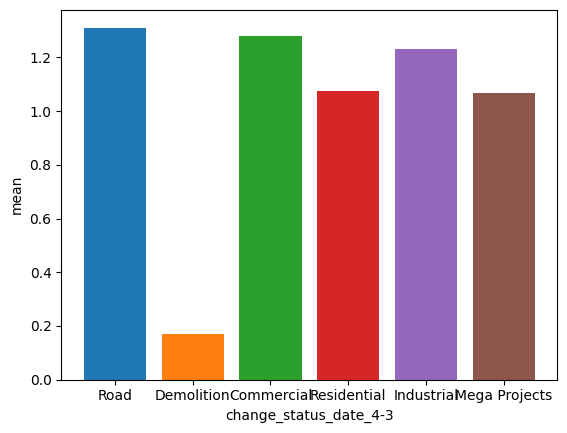

In [57]:
plotOneHot(train_df, 'change_status_date_4-3')

<h2>8) Columns: colors</h2>

We can compute the mean of the 3 colors

In [58]:

for df in [train_df, test_df]:
    for iDate in range(5):
        df[f'img_mean_date{iDate}'] = (df[f'img_red_mean_date{iDate}']+df[f'img_blue_mean_date{iDate}']+df[f'img_green_mean_date{iDate}'])/3
        df[f'img_std_date{iDate}'] = (df[f'img_red_std_date{iDate}']+df[f'img_blue_std_date{iDate}']+df[f'img_green_std_date{iDate}'])/3

We compute the variations

In [59]:
col_imgs = ["img_mean_date", "img_std_date", "img_red_mean_date", "img_green_mean_date", "img_blue_mean_date", "img_red_std_date", "img_green_std_date", "img_blue_std_date"]

# Maybe adding variations
for df in [train_df, test_df]:
    for col in col_imgs:
        df[f'{col}_4-0'] = df[f'{col}4'] - df[f'{col}0']

        df[f'{col}_1-0'] = df[f'{col}1'] - df[f'{col}0']
        df[f'{col}_2-1'] = df[f'{col}2'] - df[f'{col}1']
        df[f'{col}_3-2'] = df[f'{col}3'] - df[f'{col}2']
        df[f'{col}_4-3'] = df[f'{col}4'] - df[f'{col}3']

<AxesSubplot:xlabel='change_type', ylabel='img_std_date_4-0'>

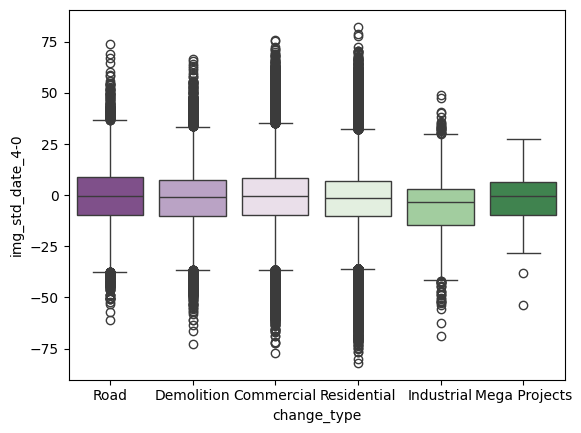

In [60]:
sns.boxplot(x="change_type", y=f'img_std_date_4-0', hue=None, data=train_df, palette="PRGn")

<AxesSubplot:xlabel='change_type', ylabel='img_mean_date0'>

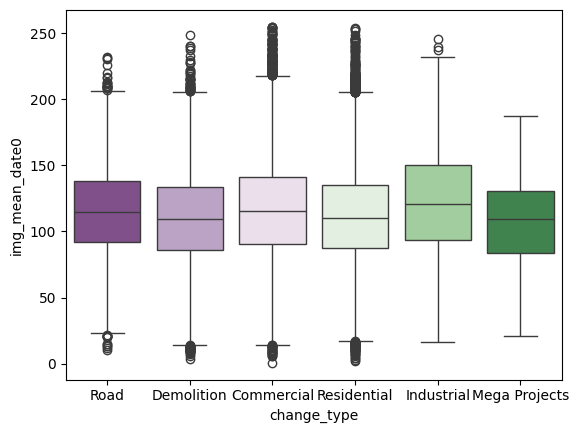

In [61]:
sns.boxplot(x="change_type", y=f'img_mean_date0', hue=None, data=train_df, palette="PRGn")

<h2>9) Columns: dates</h2>

Maybe there is no need to keep the exact dates : let's just compute the difference in days between each date

In [62]:
for df in [train_df, test_df]:
    for iDate in range(1, 5):
        df[f'date_{iDate}-{iDate-1}'] = (df[f'date{iDate}'] - df[f'date{iDate-1}']).dt.days
    df[f'date_4-0'] = (df[f'date4'] - df[f'date0']).dt.days

=== date_4-0 ===
Type : int64
Missing values (NaN) : 0 / 296146
Nb of different values : 261
=== Value counts ===
1568    8613
1817    7905
1385    6224
1773    5355
1794    4635
        ... 
2193      13
1526      11
1741      10
1594       1
2413       1
Name: date_4-0, Length: 261, dtype: int64
=== Data description ===
count    296146.00000
mean       1850.38684
std         299.68431
min        1079.00000
25%        1637.00000
50%        1817.00000
75%        2066.00000
max        3036.00000
Name: date_4-0, dtype: float64


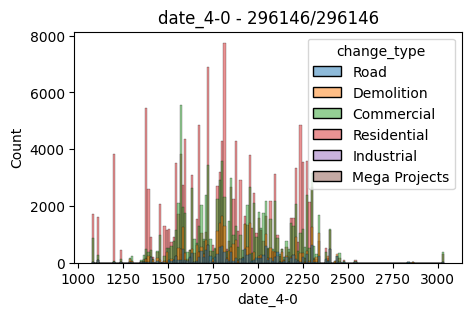

In [63]:
printInfos(train_df, 'date_4-0')

=== date_4-0 ===
Type : float64
Missing values (NaN) : 729 / 120526
Nb of different values : 128
=== Value counts ===
1568.0    6877
1385.0    6224
1669.0    4596
1731.0    4345
2297.0    3747
          ... 
2111.0      63
1954.0      50
1420.0      30
2119.0      30
1293.0      27
Name: date_4-0, Length: 128, dtype: int64
=== Data description ===
count    119797.000000
mean       1827.194053
std         334.732633
min        1081.000000
25%        1568.000000
50%        1821.000000
75%        2051.000000
max        3036.000000
Name: date_4-0, dtype: float64


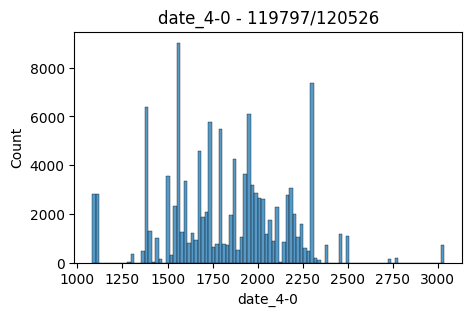

In [64]:
printInfos(test_df, "date_4-0", hue=None)

Maybe also the first day, in term of the number of days before the minimum day

In [65]:
minDay = min(train_df['date0'].min(), test_df['date0'].min())

In [66]:
minDay

Timestamp('2010-03-21 00:00:00')

In [67]:
for df in [train_df, test_df]:
    df[f'date_0-0min'] = (df['date0'] - minDay).dt.days

We can divide the variations for change_status and img

In [68]:
cols = ["img_mean_date", "img_std_date", "img_red_mean_date", "img_green_mean_date", "img_blue_mean_date", "img_red_std_date", "img_green_std_date", "img_blue_std_date", "change_status_date"]

# Maybe adding variations
for df in [train_df, test_df]:
    for col in cols:
        df[f'{col}_4-0/Date'] = df[f'{col}_4-0'] / df['date_4-0']

        df[f'{col}_1-0/Date'] = df[f'{col}_1-0'] / df['date_1-0']
        df[f'{col}_2-1/Date'] = df[f'{col}_2-1'] / df['date_2-1']
        df[f'{col}_3-2/Date'] = df[f'{col}_3-2'] / df['date_3-2']
        df[f'{col}_4-3/Date'] = df[f'{col}_4-3'] / df['date_4-3']

<AxesSubplot:xlabel='change_type', ylabel='change_status_date_4-0/Date'>

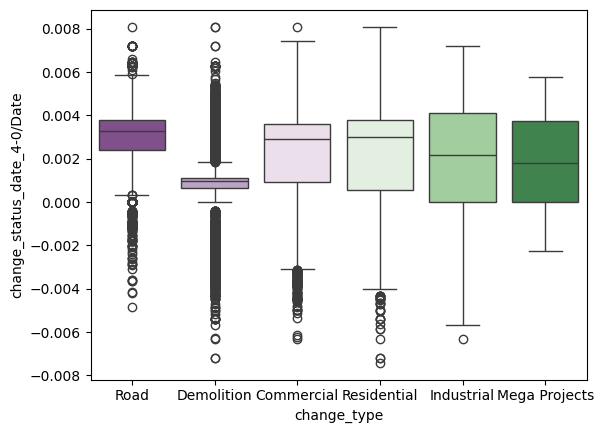

In [69]:
sns.boxplot(x="change_type", y=f'change_status_date_4-0/Date', hue=None, data=train_df, palette="PRGn")

<AxesSubplot:xlabel='change_type', ylabel='change_status_date_4-0'>

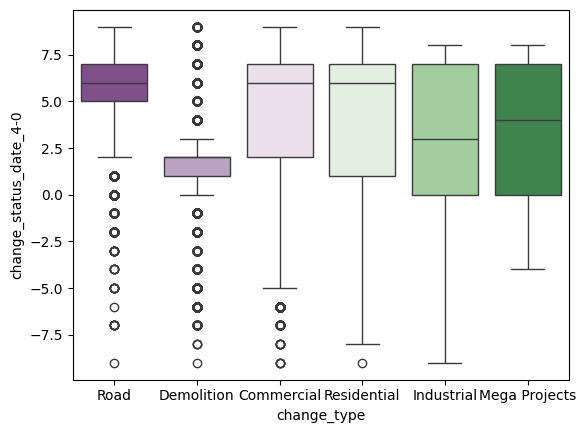

In [70]:
sns.boxplot(x="change_type", y=f'{col}_4-0', hue=None, data=train_df, palette="PRGn")

<h2>10) Polygon</h2>

<AxesSubplot:>

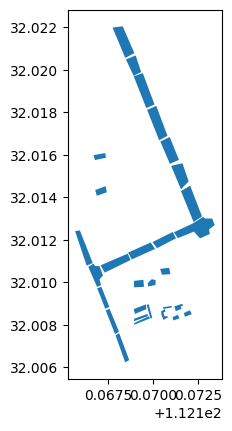

In [71]:
train_df["geometry"].head(n=30).plot()

We can compute many geometric features:

In [72]:
import shapely
from scipy.spatial import distance


def calculate_aspectratio(geom):
    # It's actually the same as bbox_ratio. Can be deleted later
    bbox = geom.bounds
    width = bbox[2] - bbox[0]  
    height = bbox[3] - bbox[1]  
    aspect_ratio = width / height
    return aspect_ratio

def calculate_diameter(geometry):
    polygon = np.array(geometry.exterior.coords)
    pairwise_distances = distance.pdist(polygon)
    diameter = pairwise_distances.max()
    return diameter

In [73]:


for df in [train_df, test_df]:
    df["geometry_area"] = df[["geometry"]].to_crs(4326).area
    df["geometry_perimeter"] = df[["geometry"]].to_crs(4326).length
    
    df['geometry_inscribed_circle_radius'] = 2 * df['geometry_area'] / df['geometry_perimeter']
    df['geometry_compactness'] = 4 * 3.141592 * df['geometry_area'] / (df['geometry_perimeter']*df['geometry_perimeter'])
    
    df['geometry_convexity'] = df["geometry"].area  / df["geometry"].convex_hull.area 
    
    df["geometry_vertices"] = df["geometry"].get_coordinates().index.value_counts(sort=False)
    
    df['geometry_bboxwidth'] = df['geometry'].bounds['maxx'] - df['geometry'].bounds['minx']
    df['geometry_bboxheight'] = df['geometry'].bounds['maxy'] - df['geometry'].bounds['miny']    
    df['geometry_bboxratio'] = df['geometry_bboxwidth'] / df['geometry_bboxheight']
    df['geometry_bboxarea'] = df['geometry_bboxwidth'] * df['geometry_bboxheight']
    df['geometry_bboxperimeter'] = 2 * (df['geometry_bboxwidth'] + df['geometry_bboxheight'])
    
    
    df['geometry_aspectratio'] = df['geometry'].apply(calculate_aspectratio)
    df['geometry_diameter'] = df['geometry'].apply(calculate_diameter)

    
    df['geometry_minumum_bounding_circle'] = df['geometry'].minimum_bounding_radius()
    df['geometry_minimum_rotated_rectangle'] = df['geometry'].minimum_rotated_rectangle().area
    
    

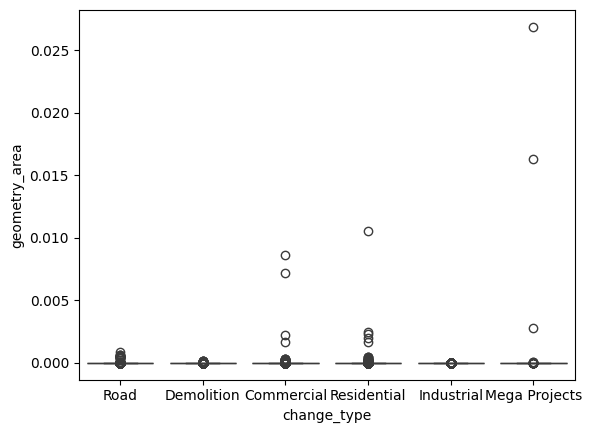

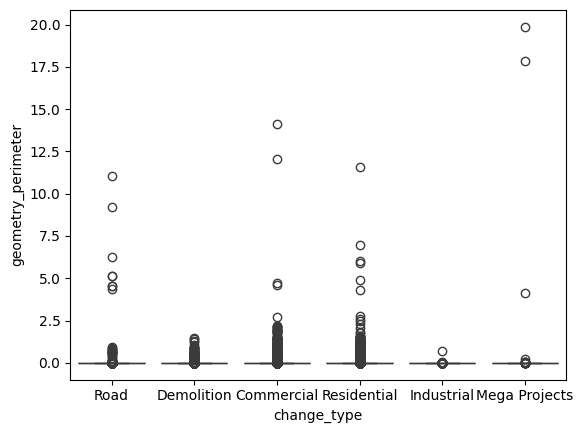

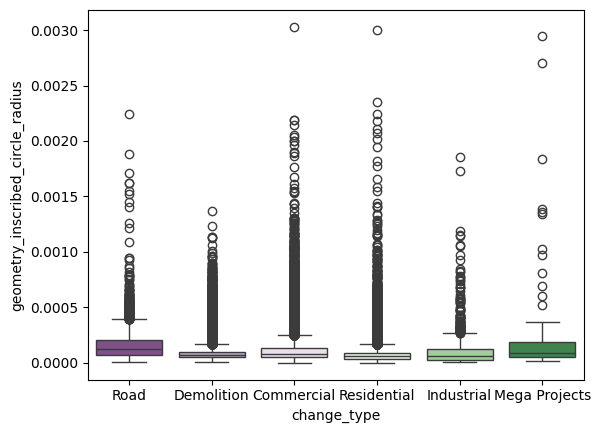

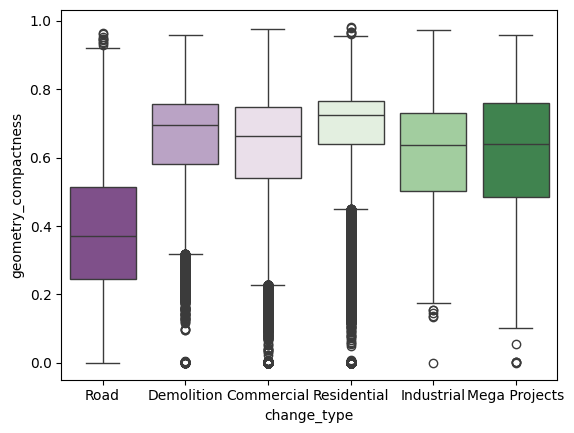

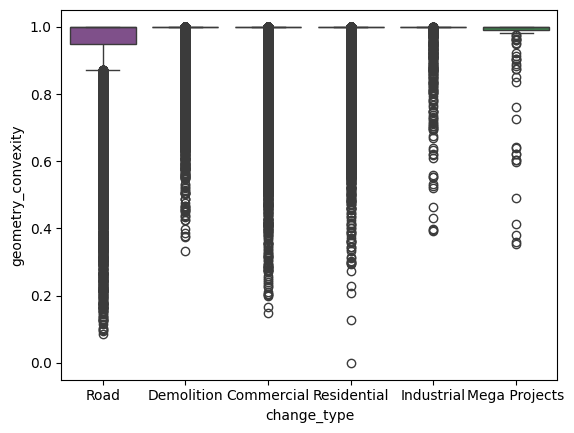

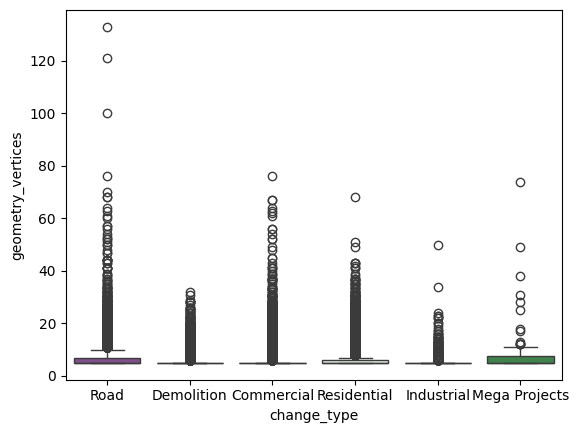

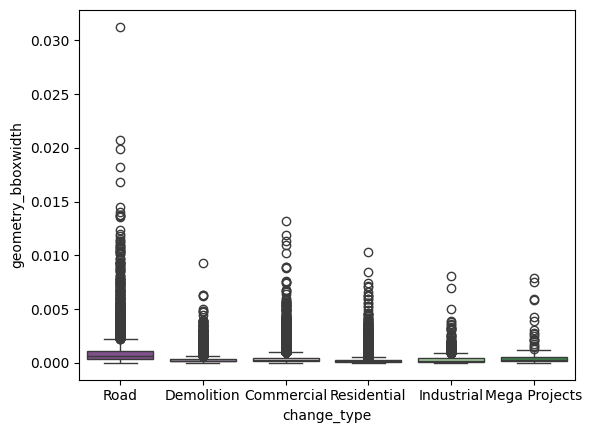

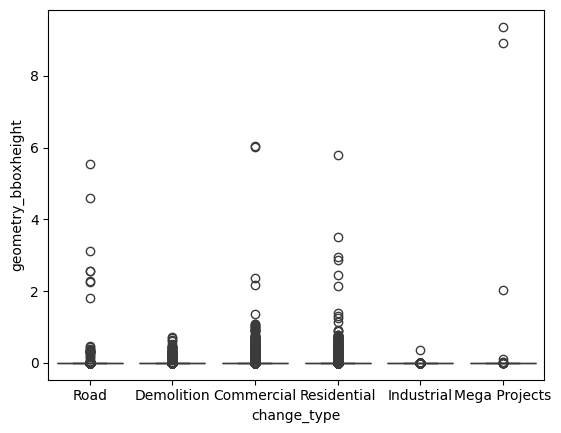

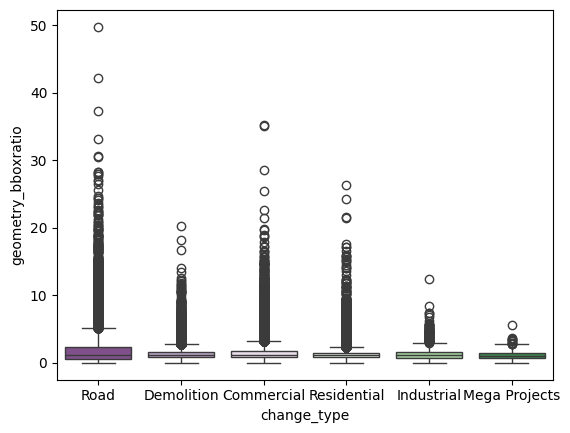

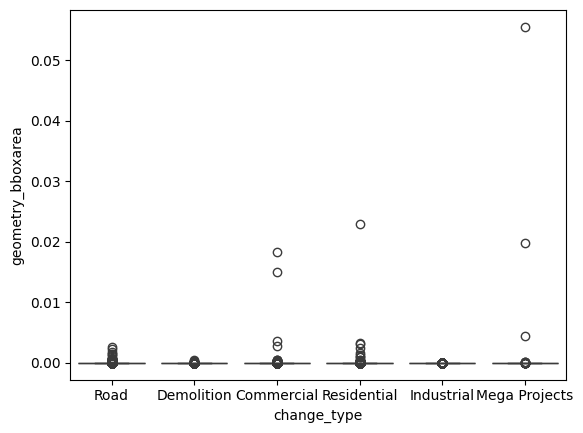

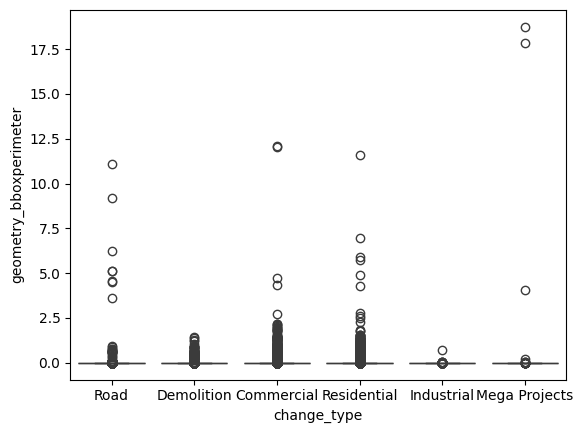

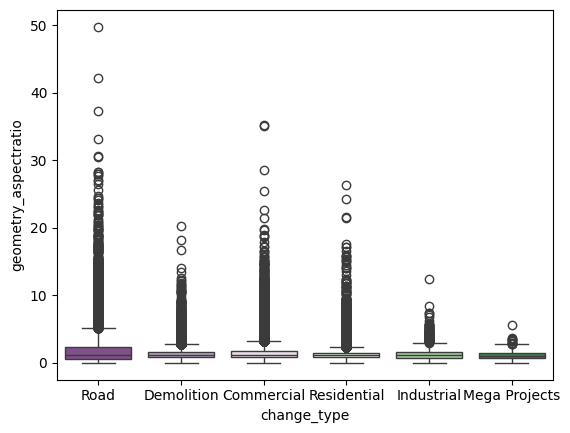

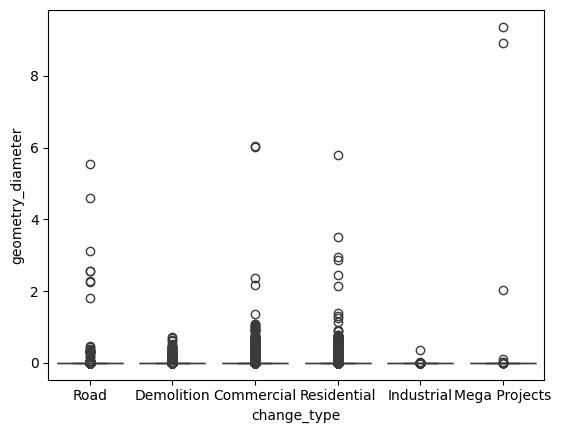

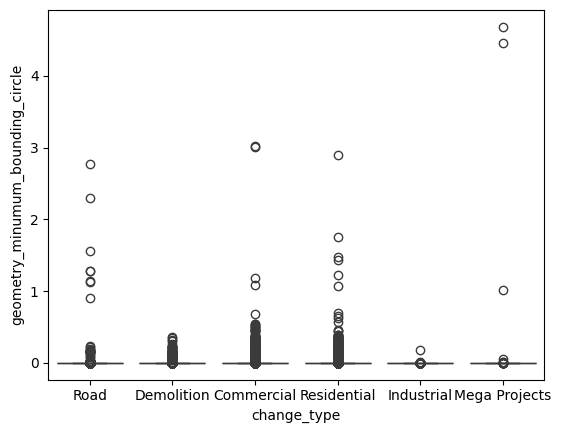

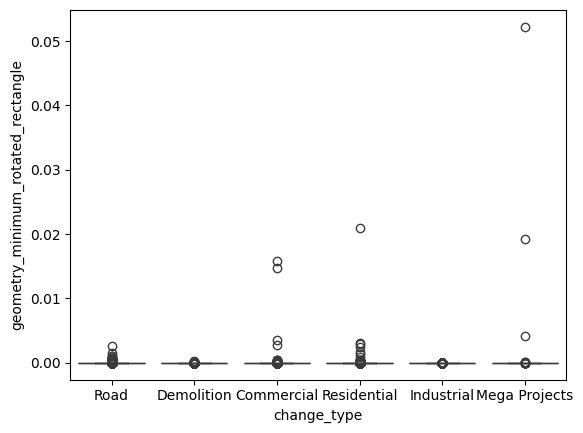

In [74]:

for col in train_df.columns:
    if col.startswith("geometry_"):
        sns.boxplot(x="change_type", y=col, hue=None, data=train_df, palette="PRGn")
        plt.show()
        

<h2>11) Save as csv</h2>

In [75]:

change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

train_df["change_type"] = train_df["change_type"].map(change_type_map)


In [76]:
train_df.to_csv("data/train_df.csv", index=False)
test_df.to_csv("data/test_df.csv", index=False)

In [77]:
train_df

urban_type                    geography_type  change_type   index  \
0       Sparse Urban           Dense Forest,Grass Land            1       0   
1       Sparse Urban           Dense Forest,Grass Land            1       1   
2       Sparse Urban           Dense Forest,Grass Land            1       2   
3              Rural           Dense Forest,Grass Land            1       3   
4        Dense Urban  Sparse Forest,Dense Forest,Farms            0       4   
...              ...                               ...          ...     ...   
296141           N,A                           Coastal            3  296141   
296142  Sparse Urban             Coastal,Sparse Forest            2  296142   
296143  Sparse Urban                      Dense Forest            2  296143   
296144  Sparse Urban                      Dense Forest            2  296144   
296145  Sparse Urban                      Dense Forest            2  296145   

                                                 geometry  urban_type_N,A  \
0       POLYGON ((112.16774 32.02198, 112.16845 32.020...             0.0   
1       POLYGON ((112.16849 32.02048, 112.16891 32.019...             0.0   
2       POLYGON ((112.16892 32.01969, 112.16962 32.018...             0.0   
3       POLYGON ((112.16966 32.01810, 112.17033 32.016...             0.0   
4       POLYGON ((112.16669 32.01597, 112.16677 32.015...             0.0   
...                                                   ...             ...   
296141  POLYGON ((-109.72152 23.00665, -109.72155 23.0...             1.0   
296142  POLYGON ((-109.71610 23.01983, -109.71617 23.0...             0.0   
296143  POLYGON ((-109.71829 23.02784, -109.71832 23.0...             0.0   
296144  POLYGON ((-109.71771 23.02794, -109.71768 23.0...             0.0   
296145  POLYGON ((-109.71784 23.02884, -109.71782 23.0...             0.0   

        urban_type_UrbanSlum  urban_type_Rural  urban_type_DenseUrban  \
0                          0                 0                      0   
1                          0                 0                      0   
2                          0                 0                      0   
3                          0                 1                      0   
4                          0                 0                      1   
...                      ...               ...                    ...   
296141                     0                 0                      0   
296142                     0                 0                      0   
296143                     0                 0                      0   
296144                     0                 0                      0   
296145                     0                 0                      0   

        urban_type_Industrial  urban_type_SparseUrban  \
0                           0                       1   
1                           0                       1   
2                           0                       1   
3                           0                       0   
4                           0                       0   
...                       ...                     ...   
296141                      0                       0   
296142                      0                       1   
296143                      0                       1   
296144                      0                       1   
296145                      0                       1   

        urban_type_Dense Urban,Industrial  urban_type_Dense Urban,Urban Slum  \
0                                     0.0                                0.0   
1                                     0.0                                0.0   
2                                     0.0                                0.0   
3                                     0.0                                0.0   
4                                     0.0                                0.0   
...                                   ...                                ...   
296141        